# Final Prject: Shoes Image Classification
### MSCA 31009 IP02 Machine Learning & Predictive Analytics
### Mia Song
- This project is based on Nicholas Renotte's tutorial, 'Build a Deep CNN Image Classifier with ANY Images,' from his YouTube channel.
- While his model is designed for binary classification, this project has been modified to classify our images into multiple classes.

# 0. Goal of Analysis
- The fashion industry is heavily reliant on manual labor, particularly for tasks like product classification on e-commerce platforms. This manual approach is not only time and resource-intensive but also prone to inaccuracies that can directly impact sales and customer satisfaction.
- In this project, we aim to address these challenges by developing a Keras-based neural network model to accurately classify five types of shoes. The objective is to enhance classification efficiency and accuracy, thereby improving product discoverability and ultimately driving sales.
- Our findings will not only optimize product listing processes but also serve as a catalyst for broader automation within the fashion industry. This research holds the potential to significantly reduce human error, save time, and increase operational efficiency.

# 1. Setup and Load Data

## 1.1. Import Necessary Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet152V2, DenseNet201, EfficientNetB1
import cv2
import imghdr
import scipy
import os
# os.path.join() function automatically handles the differences in path separators between different operating systems, making it a convenient way to construct file and directory paths that are portable and work consistently across platforms.
# os.listdir() function in Python is used to retrieve a list of files and directories present in a specified directory.
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# !unzip /content/drive/MyDrive/dataset/dataset.zip -d /content/drive/MyDrive/dataset/

## 1.2. Create Data Path
1. Class: Our data has 5 classes, which are Ballet Flat, Boat, Brogue, Clog, and Sneaker. 
2. Train/Test Split: Our data has already train/test split sets, inluding validation set. 
- Train: 2,000 in each calss, in total 10,000 images
- Test: Different number of images in each class, in total 1,215 images
- Validation: 500 in each calss, in total 25,000 images

In [3]:
# Note that our data in the folder has a hierarchy such as Shoes Dataset>Train, Test, Valid>'Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker' 
# 1st Level access to the data
data_dir = 'Shoes Dataset'

# 2nd level acess to the data
# If we put the floder's name inside of each folder, we can see all of the files in it.
# e.g. train_dir = os.path.join(data_dir, 'Train', 'Ballet Falt')
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')
valid_dir = os.path.join(data_dir, 'Valid')

In [4]:
train_test_split = ['train_dir', 'test_dir', 'valid_dir']
classes = ['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker']

# Count the number of files in each class for the train directory
print("Train files:")
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    class_files = os.listdir(class_dir)
    num_files = len(class_files)
    print(f"Class: {class_name}, Number of files: {num_files}")

# Count the number of files in each class for the test directory
print("Test files:")
for class_name in classes:
    class_dir = os.path.join(test_dir, class_name)
    class_files = os.listdir(class_dir)
    num_files = len(class_files)
    print(f"Class: {class_name}, Number of files: {num_files}")

# Count the number of files in each class for the validation directory
print("Validation files:")
for class_name in classes:
    class_dir = os.path.join(valid_dir, class_name)
    class_files = os.listdir(class_dir)
    num_files = len(class_files)
    print(f"Class: {class_name}, Number of files: {num_files}")

Train files:
Class: Ballet Flat, Number of files: 2000
Class: Boat, Number of files: 2000
Class: Brogue, Number of files: 2000
Class: Clog, Number of files: 2000
Class: Sneaker, Number of files: 2000
Test files:
Class: Ballet Flat, Number of files: 97
Class: Boat, Number of files: 236
Class: Brogue, Number of files: 192
Class: Clog, Number of files: 424
Class: Sneaker, Number of files: 266
Validation files:
Class: Ballet Flat, Number of files: 500
Class: Boat, Number of files: 500
Class: Brogue, Number of files: 500
Class: Clog, Number of files: 500
Class: Sneaker, Number of files: 500


## 1.3. Remove Dodgy Images
- Removing dodgy images is the process of eliminating or excluding low-quality or unreliable images from a dataset when training Convolutional Neural Networks (CNNs) for image classification tasks.

In [5]:
# to read the specified image with cv2.imread()
img = cv2.imread(os.path.join(train_dir, 'Ballet Flat', 'Ballet Flat-Train (1).jpeg'))

In [6]:
print(type(img))
print(img.shape) #Height*Width*RGB

<class 'numpy.ndarray'>
(225, 225, 3)


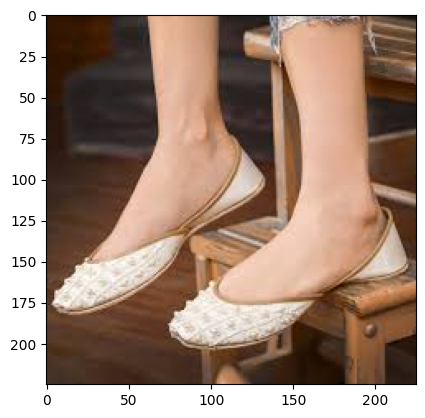

In [7]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

The image data set we will use is clean and we did not remove any images that are not in our list of acceptable file types and print out any issues it encounters during the image reading or file type checking process.

In [8]:
import os
import cv2
import imghdr

# Note that our data in the folder has a hierarchy such as Shoes Dataset>Train, Test, Valid>'Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'
data_dir = 'Shoes Dataset'

# 2nd level access to the data
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')
valid_dir = os.path.join(data_dir, 'Valid')

# List of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Define directories in a dictionary
directories = {
    'train_dir': train_dir,
    'test_dir': test_dir,
    'valid_dir': valid_dir
}

# Loop over the train, test, validation sets
for tts in directories.keys():
    # Loop over each class in the current directory
    for image_class in os.listdir(directories[tts]):
        if image_class == '.DS_Store':
            continue

        class_dir = os.path.join(directories[tts], image_class)
        # Loop over each image in the current class directory
        for image in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image)
            try:
                # Try to read the image
                img = cv2.imread(image_path)
            except Exception as e:
                print('Issue with reading image: {}'.format(image_path))
                continue

            try:
                # Check the image file type
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext list: {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with checking image type: {}'.format(image_path))

## 1.4. Load Data
- By executing the lines of code below, we will obtain the train_data / test_data / valid_data datasets, which contains batches of images and their corresponding categorical one-hot vector labels. 
- We can use this dataset for training our deep learning models using TensorFlow.

In [9]:
# data_dir = '/content/drive/MyDrive/dataset/Shoes Dataset'
# train_dir = os.path.join(data_dir, 'Train')
# test_dir = os.path.join(data_dir, 'Test')
# valid_dir = os.path.join(data_dir, 'Valid')

# default batch_size = 32

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical'
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical'
)

valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='categorical'
)

Found 10000 files belonging to 5 classes.
Metal device set to: Apple M1 Pro
Found 1215 files belonging to 5 classes.


2023-05-20 15:59:25.275202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-20 15:59:25.275328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2500 files belonging to 5 classes.


- By executing the lines of code below, we can obtain the first batch of data from each dataset as NumPy arrays. 
- This can be useful when you want to inspect or manipulate the data in NumPy format, or when you need to pass the data to other libraries or functions that expect NumPy arrays as input.

In [10]:
train_iterator = train_data.as_numpy_iterator()
test_iterator = test_data.as_numpy_iterator()
valid_iterator = valid_data.as_numpy_iterator()

In [11]:
train_iterator

In [12]:
train_batch = train_iterator.next()
test_batch = test_iterator.next()
valid_batch = valid_iterator.next()

2023-05-20 15:59:25.525084: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
print(len(train_batch))
print(len(test_batch))
print(len(valid_batch))
# The result two indicates that there are two parts in _batch.
# 1st part: Image Representations, 2nd part: Labels

2
2
2


In [14]:
print(train_batch[0].shape)
print(test_batch[0].shape)
print(valid_batch[0].shape)
# Images represents as numpy arrays
# The result (32, 256, 256, 3) indicates that the batch contains 32 images, where each image has a height and width of 256 pixels, and 3 channels representing the RGB color channels.
# The function automatically resizes the image to be the consistent size.

(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


In [15]:
print(train_batch[1].shape)
print(test_batch[1].shape)
print(valid_batch[1].shape)
# Labels represents as numpy arrays
# 32 = Batch size, 5 = Class number
# Ballet Flat (1,0,0,0,0)
# Boat (0,1,0,0,0)
# Brogue (0,0,1,0,0)
# Clog (0,0,0,1,0)
# Sneaker (0,0,0,0,1)

(32, 5)
(32, 5)
(32, 5)


### A description of each type of shoe:

1) Ballet Flat:
- Ballet flats are lightweight and flat shoes inspired by ballet slippers.
- They typically have a rounded or almond-shaped toe and a minimal heel or no heel at all.
- They are often characterized by a slim, streamlined silhouette.

2) Boat Shoes:
- Boat shoes, also known as deck shoes or topsiders, were originally designed for sailors and boating activities.
- They feature a slip-on style with laces or leather cords that wrap around the sides.
- Boat shoes are made from durable leather or canvas materials, often with a non-slip rubber sole.
- They typically have a moccasin-like construction with a low profile and a siped sole for better traction on wet surfaces.

3) Brogues:
- Brogues are characterized by decorative perforations, called broguing, along the edges and on the toe of the shoe.
- Brogues traditionally had a low heel and were made from leather, often with a wingtip design.

4) Clogs:
- Clogs are sturdy and comfortable shoes that have a solid, usually wooden, sole.
- They can be open-back or closed-back and often have a raised heel.

5) Sneakers: 
- Sneakers, also known as athletic shoes or trainers, are designed primarily for sports and physical activities.
- They are characterized by a flexible sole and an upper that provides cushioning, support, and breathability.
- Sneakers come in a wide range of styles, including low-top, high-top, and slip-on designs.

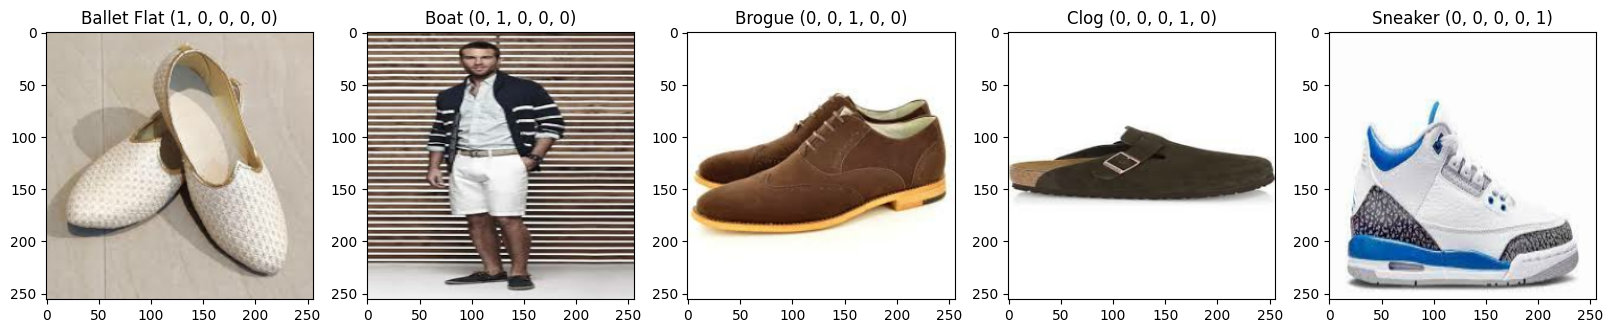

In [16]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 20))

for class_idx, class_label in enumerate(classes):
    class_images = test_batch[0][test_batch[1][:, class_idx] == 1]
    image = class_images[0]  

    label = tuple(int(val) for val in test_batch[1][test_batch[1][:, class_idx] == 1][0])
    label_str = str(label)

    ax[class_idx].imshow(image.astype(int))
    ax[class_idx].set_title(f'{class_label} {label_str}')

plt.show()

# 2. Preprocess Data: Sacling
- Preporcessing process often involves with data scaling and spliting. Since our data set is originally divided into three parts, train, test and validation images, we will focus on scaling. However, we will examine why we need to preprocess our data before building a neural network model.

1. Scaling:
- Scaling can be done by dividing the pixel values by the maximum value (e.g., 255) to normalize them to a range of 0 to 1.
- Scaling the image data helps ensure that all pixel values are within a similar range, which can improve the model's convergence and training stability.

2. Spliiting:
- The purpose of splitting the image data is to ensure that the model is trained and evaluated on different subsets of the data. This helps us assess the model's performance on unseen images and make improvements to enhance its ability to generalize well to new data.

## 2.1. Scaling 

In [17]:
train_data
# x = images, y = labels

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [18]:
# The map() function is a transformation operation that applies a specified function to each element of the dataset. 
# It allows us to perform element-wise operations or transformations on the data within the dataset.
# 255: This is because pixel values for standard color images range between 0 and 255
train_data_scaled = train_data.map(lambda x, y: (x/255, y))
test_data_scaled = test_data.map(lambda x, y: (x/255, y))
valid_data_scaled = valid_data.map(lambda x, y: (x/255, y))

In [19]:
train_batch_size = tf.data.experimental.cardinality(train_data_scaled).numpy()
test_batch_size = tf.data.experimental.cardinality(test_data_scaled).numpy()
valid_batch_size = tf.data.experimental.cardinality(valid_data_scaled).numpy()
# The tf.data.experimental.cardinality function then counts the number of batches, not the total number of images.
# When batched into groups of 32, you get 312.5 batches. Since a batch cannot be a fraction, the last batch will have less than 32 images, but it will still be counted as a full batch. Therefore, the cardinality function returns 313, which represents the number of batches, not the number of images.

print("Number of images in the training set:", train_batch_size * 32)
print("Number of images in the test set:", test_batch_size * 32)
print("Number of images in the validation set:", valid_batch_size * 32)

Number of images in the training set: 10016
Number of images in the test set: 1216
Number of images in the validation set: 2528


In [20]:
train_scaled_iterator = train_data_scaled.as_numpy_iterator()
test_scaled_iterator = test_data_scaled.as_numpy_iterator()
valid_scaled_iterator = valid_data_scaled.as_numpy_iterator()

In [21]:
train_scaled_batch = train_scaled_iterator.next()
test_scaled_batch = test_scaled_iterator.next()
valid_scaled_batch = valid_scaled_iterator.next()

In [22]:
print(train_scaled_batch[0].min(), train_scaled_batch[0].max())
print(test_scaled_batch[0].min(), test_scaled_batch[0].max())
print(valid_scaled_batch[0].min(), valid_scaled_batch[0].max())

0.0 1.0
0.0 1.0
0.0 1.0


## 2.2. Spliting
- If our data initially is not divided into train, test, validation sets, then we can apply the startegy manually.
- Decide the batch size for train/test/validation split
    1. len(data): referes to the batch size 
    2. tarin_size = int(len(data)*0.7)
    3. val_szie = int(len(data)*0.2)+1(+1 is optional to compensate discrepancy)
    4. test_size = int(len(data)*0.1)+1(+1 is optional to compensate discrepancy)
    5. train_size + val_size + test_size = len(data)
- Take and Skip 
    1. train = data.take(train_size)
    2. val = data.skip(train_size).take(val_size)
    3. test = data.skip(train_size+val_size).take(test_size)

# 3. Build a Deep Learning Model

## 3.1. Build a Deep Learning Model

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), strides=1, activation = 'relu', input_shape=(256,256,3)))
# Model Architencture: Conv2D(the number of filters, (the size of filters), a stride(the step size of a filter), activation function,  the size of input shape)
# Choose the appropirate activation function matters. 
# In convolutional neural networks (CNNs), it is more common to increase the number of filters in each subsequent convolutional layer. 
# Feature hierarchy: By increasing the number of filters, we allow the network to learn more of these complex features.
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), strides=1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), strides=1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())
# Change our values in the channel down to a single value, i.e. condense dowin into a single layer

model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax')) 
# Use sigmoid activation for binary classification, softmax activation for multiclass classification

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

## 3.2. Train Our Model

In [27]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

- The validation data comes into play after each epoch of training. After an epoch, the model uses the validation data to assess its performance. It makes predictions on the validation data and compares those predictions to the actual targets. 
- This use of validation data is essential for a few reasons:
    1. Detecting Overfitting
    2. Hyperparameter Tuning
    3. Early Stopping

In [28]:
hist1 = model.fit(train_data_scaled, 
                 epochs = 20, 
                 validation_data = valid_data_scaled, 
                 callbacks = [tensorboard_callback])

Epoch 1/20


2023-05-20 15:59:26.727431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 1.5833 - accuracy: 0.3471

2023-05-20 15:59:44.543716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 20s 62ms/step - loss: 1.5833 - accuracy: 0.3471 - val_loss: 1.3915 - val_accuracy: 0.4116
Epoch 2/20
313/313 [==============================] - 19s 61ms/step - loss: 1.1850 - accuracy: 0.5334 - val_loss: 1.2482 - val_accuracy: 0.5124
Epoch 3/20
313/313 [==============================] - 19s 61ms/step - loss: 0.8184 - accuracy: 0.6982 - val_loss: 1.4418 - val_accuracy: 0.5220
Epoch 4/20
313/313 [==============================] - 19s 62ms/step - loss: 0.4666 - accuracy: 0.8336 - val_loss: 1.8427 - val_accuracy: 0.5452
Epoch 5/20
313/313 [==============================] - 19s 61ms/step - loss: 0.2460 - accuracy: 0.9148 - val_loss: 2.2336 - val_accuracy: 0.5288
Epoch 6/20
313/313 [==============================] - 19s 61ms/step - loss: 0.1435 - accuracy: 0.9540 - val_loss: 2.6560 - val_accuracy: 0.5504
Epoch 7/20
313/313 [==============================] - 19s 61ms/step - loss: 0.0896 - accuracy: 0.9719 - val_loss: 2.9196 - val_accuracy: 0.5440
Epo

## 3.3. Save the Model

##### Serialization Model
- In the context of Convolutional Neural Networks (CNNs), serialization refers to the process of saving a trained model's parameters and architecture to a file, which can then be later loaded and used for inference or further training.
- Serialization allows you to save these learned parameters and the architecture of the CNN model to a file format that can be stored on disk or transferred over the network. This saved model can be reloaded at a later time, even on a different machine or in a different programming environment, to perform inference tasks without the need to retrain the model from scratch.

In [29]:
model.save(os.path.join('models', 'model1.h5'))
# Serializing a model (.h5 = serialization model)
# model2 = load_model(os.path.join('models', 'model1.h5'))

In [30]:
model1 = load_model('models/model1.h5')

## 3.4. Estimate Performance with Plots

### 3.4.1. Loss Logs
- We observe a slight spike after a few spokes.
- This could be due to:
1. Stochastic nature of training
2. Learning rate too high(=overshooting)
3. Overfitting
4. Insufficient Regularization
- However, minor spikes in the validation loss during training can be a common occurrence and aren't necessarily indicative of a problem.

In [31]:
valid_loss, valid_accuracy = model1.evaluate(valid_data_scaled)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

 3/79 [>.............................] - ETA: 2s - loss: 5.5871 - accuracy: 0.5312 

2023-05-20 16:05:50.333139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 21ms/step - loss: 5.1604 - accuracy: 0.5456
Validation loss: 5.160431861877441, Validation accuracy: 0.5455999970436096


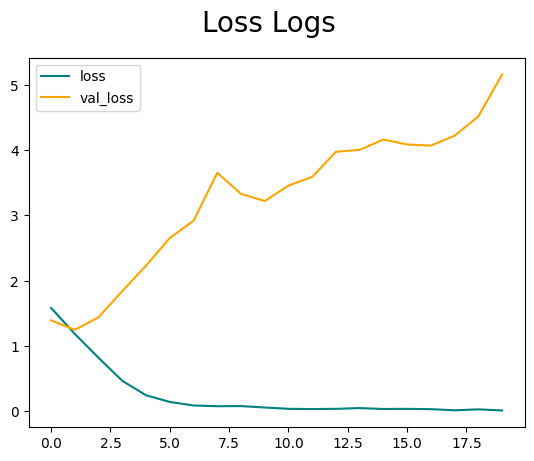

In [32]:
fig = plt.figure()
plt.plot(hist1.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist1.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m1val.png', transparent=True)
plt.show()

### 3.4.2. Accuracy Logs

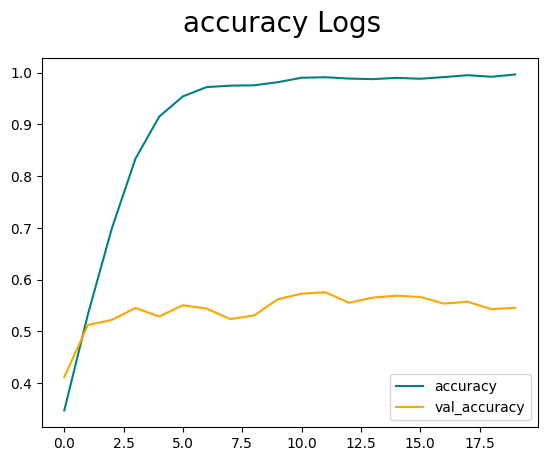

In [33]:
fig = plt.figure()
plt.plot(hist1.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist1.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m1acc.png', transparent=True)
plt.show()

# 4. Evaluate Performance

## 4.1. Evaluate a Model through Classification Report

In [34]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [35]:
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model1.predict(X, verbose = 0)
    # The verbose argument is used in some methods of Keras models, like fit(), evaluate(), and predict(), to control how much information is printed during the execution of these methods.
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())
# The result() method of a metric object in TensorFlow returns the current value of the metric as a tensor. 
# Calling .numpy() on this tensor converts it to a numpy array.

2023-05-20 16:05:52.440727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.54825294
Recall: 0.54238683
Accuracy: 0.54485595


2023-05-20 16:05:54.503286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### The lines of code is to create a classification report for each class.

In [36]:
# Empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model1.predict(X, verbose = 0)

    # Convert predictions from probabilities to class labels
    yhat_classes = np.argmax(yhat, axis=1)

    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])
print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.38      0.41      0.39        97
        Boat       0.45      0.34      0.39       236
      Brogue       0.50      0.95      0.66       192
        Clog       0.64      0.49      0.56       424
     Sneaker       0.62      0.56      0.59       266

    accuracy                           0.54      1215
   macro avg       0.52      0.55      0.52      1215
weighted avg       0.56      0.54      0.53      1215



## 4.2. Test Our Model 

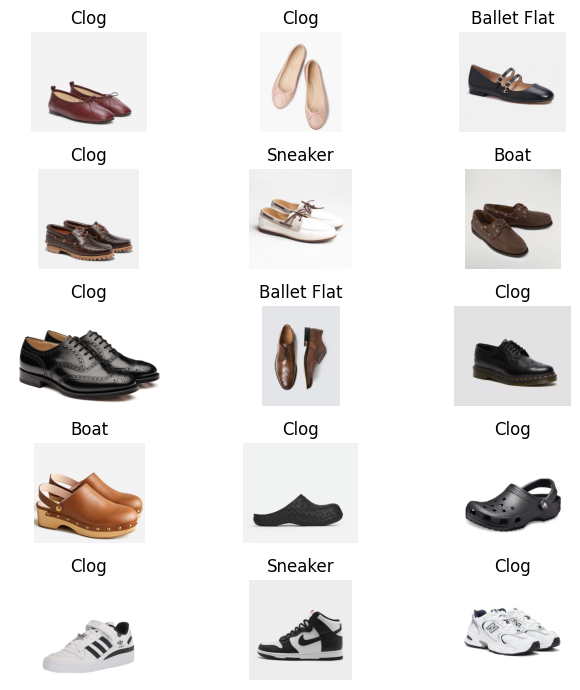

In [37]:
shoe_list2 = ['Ballet Flat', 'Ballet Flat2', 'Ballet Flat3', 'Boat', 'Boat2', 'Boat3', 'Brogue', 'Brogue2', 'Brogue3', 'Clog', 'Clog2', 'Clog3', 'Sneaker', 'Sneaker2', 'Sneaker3']
class_dict2 = {
    0: 'Ballet Flat',
    1: 'Boat',
    2: 'Brogue',
    3: 'Clog',
    4: 'Sneaker'
}

fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model1.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

### Comparison with Regularization

In [38]:
# Build a Model
model = Sequential()
model.add(Conv2D(16, (3,3), strides=1, activation = 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), strides=1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), strides=1, activation = 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add a regularization
early_stop = EarlyStopping(monitor='val_loss', patience=2)
hist2 = model.fit(train_data_scaled, 
                 epochs = 20, 
                 validation_data = valid_data_scaled, 
                 callbacks = [early_stop, tensorboard_callback]
                  )

Epoch 1/20


2023-05-20 16:05:58.287168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 1.5792 - accuracy: 0.3321

2023-05-20 16:06:16.039517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 20s 61ms/step - loss: 1.5792 - accuracy: 0.3321 - val_loss: 1.4509 - val_accuracy: 0.4100
Epoch 2/20
313/313 [==============================] - 19s 61ms/step - loss: 1.2537 - accuracy: 0.4983 - val_loss: 1.2384 - val_accuracy: 0.5048
Epoch 3/20
313/313 [==============================] - 19s 61ms/step - loss: 0.9060 - accuracy: 0.6561 - val_loss: 1.3483 - val_accuracy: 0.5192
Epoch 4/20
313/313 [==============================] - 19s 62ms/step - loss: 0.5047 - accuracy: 0.8229 - val_loss: 1.7604 - val_accuracy: 0.5256


In [39]:
# Save the model
model.save(os.path.join('models', 'model2.h5'))
model2 = load_model('models/model2.h5')

 3/79 [>.............................] - ETA: 2s - loss: 2.0426 - accuracy: 0.4688 

2023-05-20 16:07:15.859580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 21ms/step - loss: 1.7604 - accuracy: 0.5256
Validation loss: 1.7603930234909058, Validation accuracy: 0.525600016117096


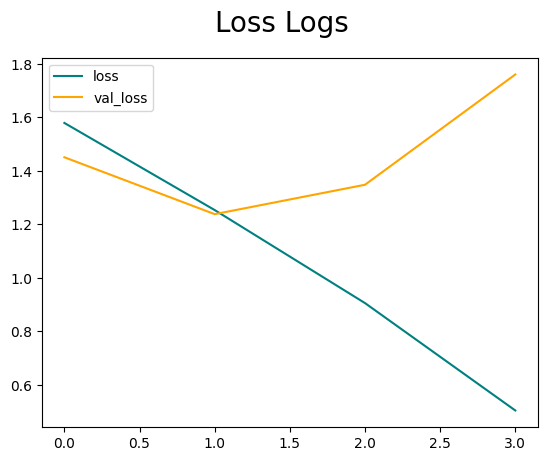

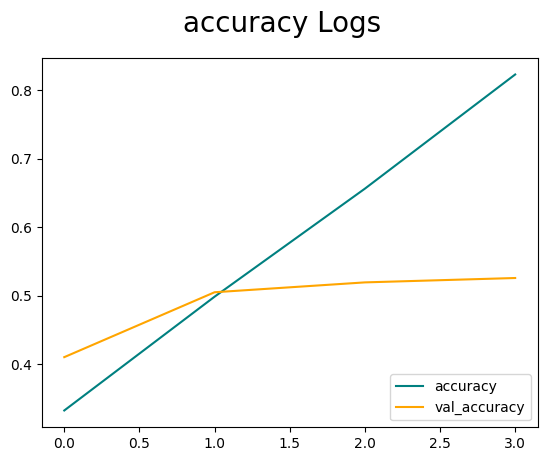

In [40]:
valid_loss, valid_accuracy = model2.evaluate(valid_data_scaled)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

# Loss Log
fig = plt.figure()
plt.plot(hist2.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist2.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m2val.png', transparent=True)
plt.show()

# Accuracy Log
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist2.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m2acc.png', transparent=True)
plt.show()

In [41]:
pre.reset_states()
re.reset_states()
acc.reset_states()

# Classification Matrix for a Model
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model2.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-20 16:07:18.035259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.57348704
Recall: 0.491358
Accuracy: 0.5374486


2023-05-20 16:07:20.072483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [42]:
y_true = []
y_pred = []

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model2.predict(X, verbose = 0)

    yhat_classes = np.argmax(yhat, axis=1)
    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])
print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.27      0.39      0.32        97
        Boat       0.51      0.24      0.33       236
      Brogue       0.63      0.82      0.72       192
        Clog       0.56      0.62      0.58       424
     Sneaker       0.57      0.52      0.55       266

    accuracy                           0.54      1215
   macro avg       0.51      0.52      0.50      1215
weighted avg       0.54      0.54      0.53      1215



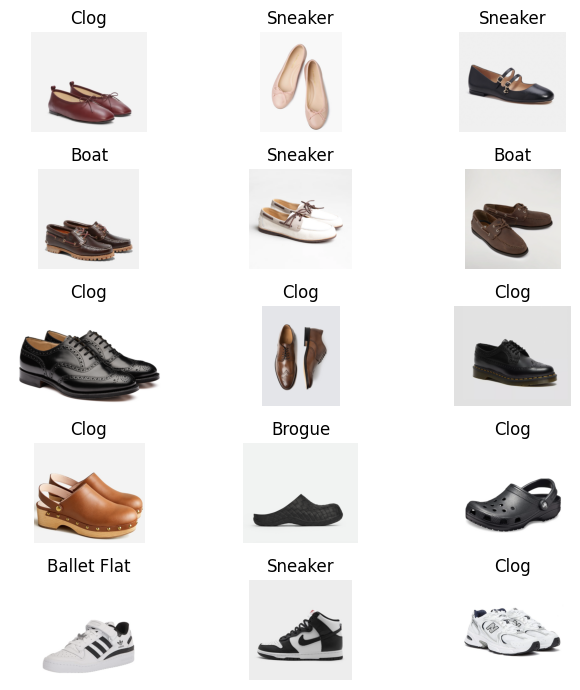

In [43]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model2.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

# 6. Improve the Existing Model

## 6.1. Data Augmentation
- Data augmentation artificially increases the size of your training set by creating modified versions of images in the dataset. This can help improve the performance and generalization of your model.
- We can use the ImageDataGenerator class from Keras to easily augment your data.

In [44]:
# Create a data generator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a data generator for validation data without data augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_directory method to load images from the directories
train_data_gen = train_datagen.flow_from_directory(train_dir)
valid_data_gen = valid_datagen.flow_from_directory(valid_dir)

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


### without early stopping

In [45]:
# Train the model using fit method
model1 = load_model('models/model1.h5')

hist3 = model1.fit(
    train_data_gen, 
    epochs=100, 
    validation_data=valid_data_gen, 
    callbacks=[tensorboard_callback]
)

Epoch 1/100


2023-05-20 16:07:24.466965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 1.5592 - accuracy: 0.3523

2023-05-20 16:08:31.529805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 69s 220ms/step - loss: 1.5592 - accuracy: 0.3523 - val_loss: 1.3491 - val_accuracy: 0.4336
Epoch 2/100
313/313 [==============================] - 69s 219ms/step - loss: 1.3591 - accuracy: 0.4362 - val_loss: 1.1950 - val_accuracy: 0.5340
Epoch 3/100
313/313 [==============================] - 69s 219ms/step - loss: 1.3085 - accuracy: 0.4734 - val_loss: 1.1861 - val_accuracy: 0.5416
Epoch 4/100
313/313 [==============================] - 69s 219ms/step - loss: 1.2624 - accuracy: 0.4901 - val_loss: 1.1487 - val_accuracy: 0.5628
Epoch 5/100
313/313 [==============================] - 69s 221ms/step - loss: 1.2292 - accuracy: 0.5148 - val_loss: 1.0972 - val_accuracy: 0.5868
Epoch 6/100
313/313 [==============================] - 69s 219ms/step - loss: 1.2006 - accuracy: 0.5169 - val_loss: 1.0492 - val_accuracy: 0.5940
Epoch 7/100
313/313 [==============================] - 69s 219ms/step - loss: 1.1803 - accuracy: 0.5352 - val_loss: 1.0278 - val_accurac

In [46]:
# Save the model
model1.save(os.path.join('models', 'model3.h5'))
model3 = load_model('models/model3.h5')

 3/79 [>.............................] - ETA: 1s - loss: 0.9135 - accuracy: 0.7500 

2023-05-20 18:02:19.081511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 23ms/step - loss: 0.8782 - accuracy: 0.7468
Validation loss: 0.8782365322113037, Validation accuracy: 0.7468000054359436


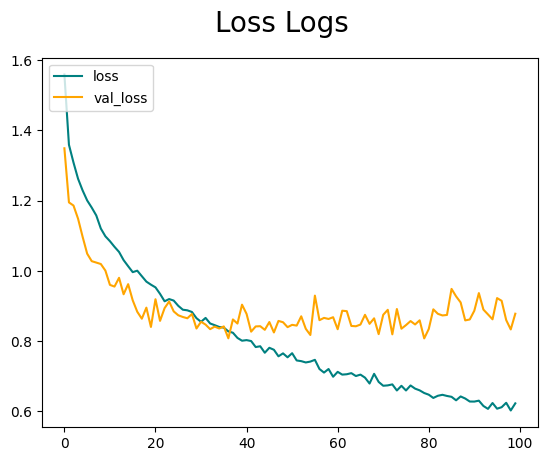

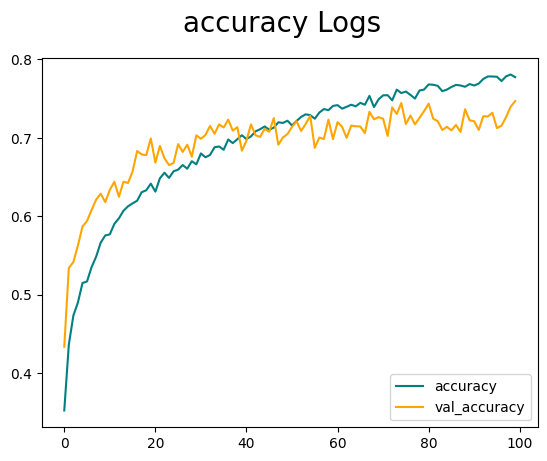

In [47]:
valid_loss, valid_accuracy = model3.evaluate(valid_data_gen)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

fig = plt.figure()
plt.plot(hist3.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist3.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m3val.png', transparent=True)
plt.show()

fig = plt.figure()
plt.plot(hist3.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist3.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m3acc.png', transparent=True)
plt.show()

In [48]:
pre.reset_states()
re.reset_states()
acc.reset_states()

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model3.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())
# The result() method of a metric object in TensorFlow returns the current value of the metric as a tensor. 
# Calling .numpy() on this tensor converts it to a numpy array.

2023-05-20 18:02:21.296969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.7339357
Recall: 0.60164607
Accuracy: 0.6617284


2023-05-20 18:02:23.339312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [49]:
# Empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model3.predict(X, verbose = 0)

    # Convert predictions from probabilities to class labels
    yhat_classes = np.argmax(yhat, axis=1)
    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)
    
# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.46      0.64      0.54        97
        Boat       0.60      0.53      0.56       236
      Brogue       0.70      0.82      0.75       192
        Clog       0.77      0.62      0.69       424
     Sneaker       0.64      0.74      0.69       266

    accuracy                           0.66      1215
   macro avg       0.64      0.67      0.65      1215
weighted avg       0.67      0.66      0.66      1215



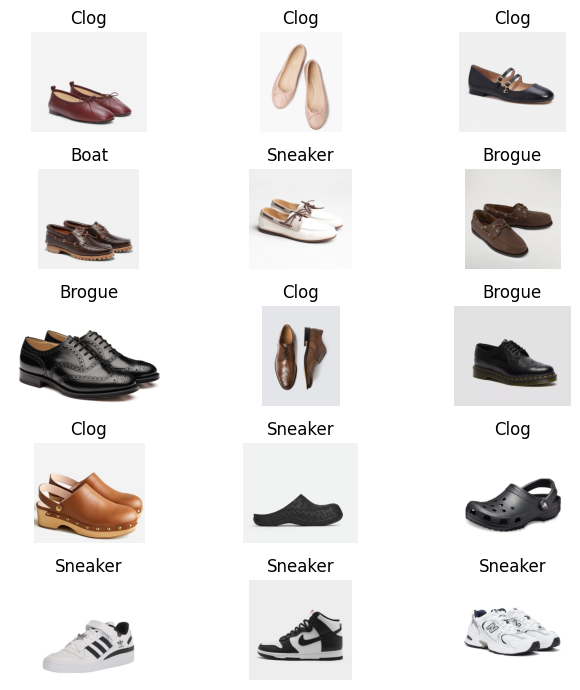

In [50]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model3.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

### with early stopping

In [51]:
model1 = load_model('models/model1.h5')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

hist4 = model1.fit(
    train_data_gen, 
    epochs=100, 
    validation_data=valid_data_gen, 
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/100


2023-05-20 18:02:27.490030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 1.5672 - accuracy: 0.3540

2023-05-20 18:03:34.673549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 69s 220ms/step - loss: 1.5672 - accuracy: 0.3540 - val_loss: 1.3737 - val_accuracy: 0.4352
Epoch 2/100
313/313 [==============================] - 69s 219ms/step - loss: 1.3944 - accuracy: 0.4156 - val_loss: 1.2774 - val_accuracy: 0.4948
Epoch 3/100
313/313 [==============================] - 69s 219ms/step - loss: 1.3260 - accuracy: 0.4635 - val_loss: 1.1894 - val_accuracy: 0.5424
Epoch 4/100
313/313 [==============================] - 69s 219ms/step - loss: 1.2839 - accuracy: 0.4861 - val_loss: 1.1917 - val_accuracy: 0.5132
Epoch 5/100
313/313 [==============================] - 69s 219ms/step - loss: 1.2366 - accuracy: 0.5141 - val_loss: 1.1273 - val_accuracy: 0.5704
Epoch 6/100
313/313 [==============================] - 69s 219ms/step - loss: 1.2072 - accuracy: 0.5233 - val_loss: 1.0544 - val_accuracy: 0.5984
Epoch 7/100
313/313 [==============================] - 69s 219ms/step - loss: 1.1688 - accuracy: 0.5431 - val_loss: 1.0439 - val_accurac

In [52]:
# Save the model
model1.save(os.path.join('models', 'model4.h5'))
model4 = load_model('models/model4.h5')

 3/79 [>.............................] - ETA: 1s - loss: 0.9922 - accuracy: 0.6562 

2023-05-20 18:57:29.442249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 23ms/step - loss: 0.8711 - accuracy: 0.6884
Validation loss: 0.8711448311805725, Validation accuracy: 0.6883999705314636


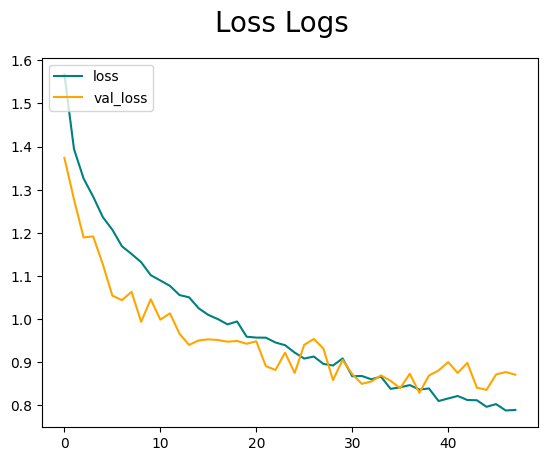

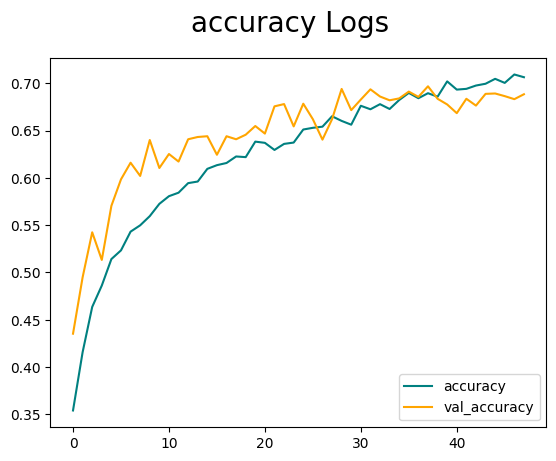

In [53]:
valid_loss, valid_accuracy = model4.evaluate(valid_data_gen)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

fig = plt.figure()
plt.plot(hist4.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist4.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m4val.png', transparent=True)
plt.show()

fig = plt.figure()
plt.plot(hist4.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist4.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m4acc.png', transparent=True)
plt.show()

In [54]:
pre.reset_states()
re.reset_states()
acc.reset_states()

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model4.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-20 18:57:31.683935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.6798246
Recall: 0.51028806
Accuracy: 0.6090535


2023-05-20 18:57:33.726472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [55]:
y_true = []
y_pred = []

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model4.predict(X, verbose = 0)

    # Convert predictions from probabilities to class labels
    yhat_classes = np.argmax(yhat, axis=1)

    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.49      0.62      0.55        97
        Boat       0.47      0.56      0.51       236
      Brogue       0.58      0.73      0.65       192
        Clog       0.76      0.54      0.64       424
     Sneaker       0.66      0.66      0.66       266

    accuracy                           0.61      1215
   macro avg       0.59      0.62      0.60      1215
weighted avg       0.63      0.61      0.61      1215



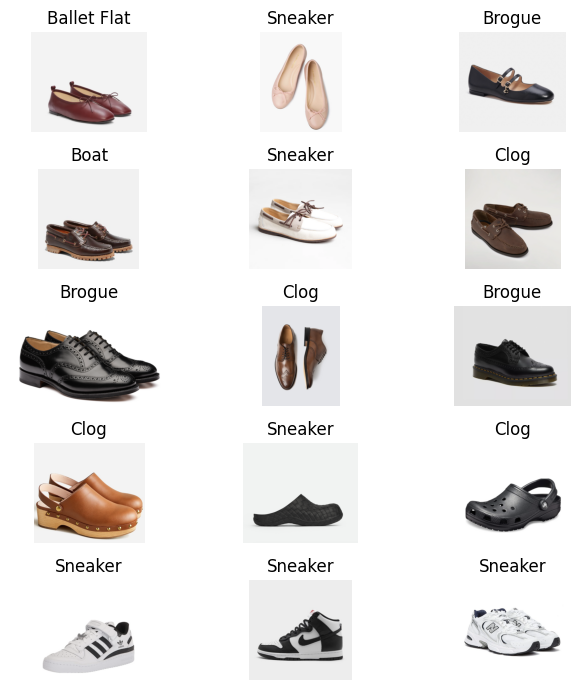

In [56]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model4.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

## 6.2. Transfer Learning
- Transfer learning involves using a pre-trained model (usually trained on a large dataset) as a starting point for our task. 
- This can significantly improve performance, especially if we don't have a large dataset.

### 6.2.1. ResNet152V2

In [57]:
res_base = ResNet152V2(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

model = Sequential()
model.add(res_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax')) 

# Freeze the base model
res_base.trainable = False

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
hist5 = model.fit(train_data_scaled, 
                 epochs = 20, 
                 validation_data = valid_data_scaled, 
                 callbacks = [tensorboard_callback]
                 )


Epoch 1/20


2023-05-20 18:57:43.291444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 2.1014 - accuracy: 0.7226

2023-05-20 18:59:49.679191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 162s 501ms/step - loss: 2.1014 - accuracy: 0.7226 - val_loss: 0.6457 - val_accuracy: 0.7908
Epoch 2/20
313/313 [==============================] - 152s 486ms/step - loss: 0.3554 - accuracy: 0.8795 - val_loss: 0.7499 - val_accuracy: 0.8136
Epoch 3/20
313/313 [==============================] - 152s 486ms/step - loss: 0.1902 - accuracy: 0.9341 - val_loss: 0.7105 - val_accuracy: 0.8176
Epoch 4/20
313/313 [==============================] - 152s 486ms/step - loss: 0.1251 - accuracy: 0.9551 - val_loss: 0.7723 - val_accuracy: 0.8076
Epoch 5/20
313/313 [==============================] - 152s 486ms/step - loss: 0.0984 - accuracy: 0.9632 - val_loss: 0.8248 - val_accuracy: 0.8164
Epoch 6/20
313/313 [==============================] - 152s 486ms/step - loss: 0.0870 - accuracy: 0.9671 - val_loss: 0.8214 - val_accuracy: 0.8204
Epoch 7/20
313/313 [==============================] - 152s 486ms/step - loss: 0.0759 - accuracy: 0.9711 - val_loss: 1.2470 - val_accura

In [58]:
# Save the model
model.save(os.path.join('models', 'model5.h5'))
model5 = load_model('models/model5.h5')

2023-05-20 19:48:33.994299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 35s 407ms/step - loss: 1.4828 - accuracy: 0.8124
Validation loss: 1.4828442335128784, Validation accuracy: 0.8123999834060669


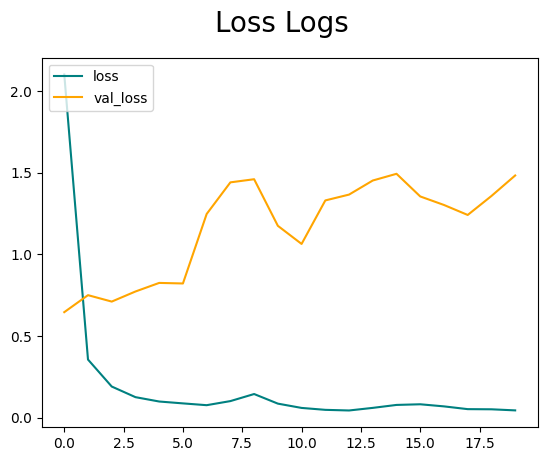

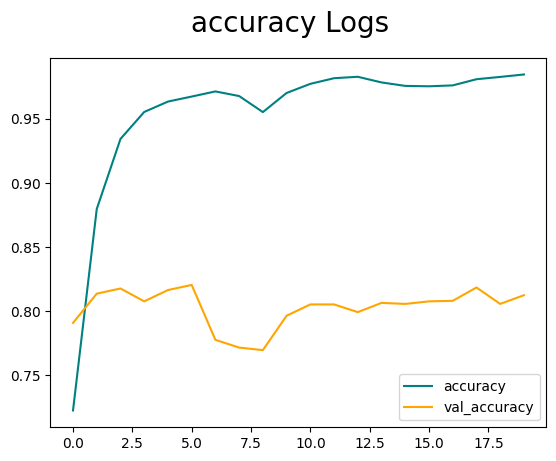

In [59]:
valid_loss, valid_accuracy = model5.evaluate(valid_data_scaled)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

fig = plt.figure()
plt.plot(hist5.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist5.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m5val.png', transparent=True)
plt.show()

fig = plt.figure()
plt.plot(hist5.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist5.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m5acc.png', transparent=True)
plt.show()

In [60]:
pre.reset_states()
re.reset_states()
acc.reset_states()

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model5.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())
# The result() method of a metric object in TensorFlow returns the current value of the metric as a tensor. 
# Calling .numpy() on this tensor converts it to a numpy array.

2023-05-20 19:49:09.419217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 19:49:28.420606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.82462054
Recall: 0.80493826
Accuracy: 0.81152266


In [61]:
# Empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model5.predict(X, verbose = 0)

    # Convert predictions from probabilities to class labels
    yhat_classes = np.argmax(yhat, axis=1)

    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.56      0.76      0.65        97
        Boat       0.79      0.66      0.72       236
      Brogue       0.84      0.96      0.90       192
        Clog       0.86      0.84      0.85       424
     Sneaker       0.85      0.80      0.83       266

    accuracy                           0.81      1215
   macro avg       0.78      0.81      0.79      1215
weighted avg       0.82      0.81      0.81      1215



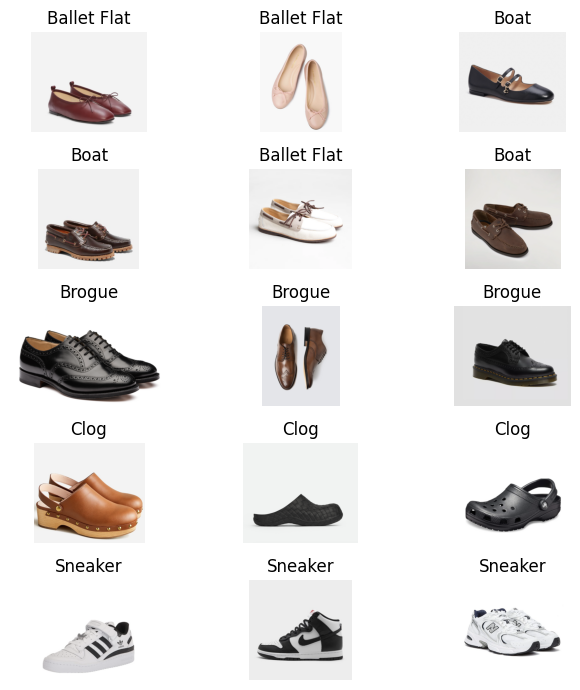

In [62]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model5.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

### Regularization

In [63]:
# Build a Model
res_base = ResNet152V2(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

model = Sequential()
model.add(res_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax')) 
res_base.trainable = False
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Add a regularization
early_stop = EarlyStopping(monitor='val_loss', patience=2)
hist6 = model.fit(train_data_scaled, 
                 epochs = 20, 
                 validation_data = valid_data_scaled, 
                 callbacks = [early_stop, tensorboard_callback]
                 )

Epoch 1/20


2023-05-20 19:50:01.143193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 1.8345 - accuracy: 0.7357

2023-05-20 19:52:10.756977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 168s 514ms/step - loss: 1.8345 - accuracy: 0.7357 - val_loss: 0.5639 - val_accuracy: 0.8044
Epoch 2/20
313/313 [==============================] - 153s 487ms/step - loss: 0.3078 - accuracy: 0.8966 - val_loss: 0.5865 - val_accuracy: 0.8196
Epoch 3/20
313/313 [==============================] - 152s 487ms/step - loss: 0.1632 - accuracy: 0.9439 - val_loss: 0.6201 - val_accuracy: 0.8308


In [64]:
# Save the model
model.save(os.path.join('models', 'model6.h5'))
model6 = load_model('models/model6.h5')

2023-05-20 19:57:54.990476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 38s 417ms/step - loss: 0.6201 - accuracy: 0.8308
Validation loss: 0.620143473148346, Validation accuracy: 0.8307999968528748


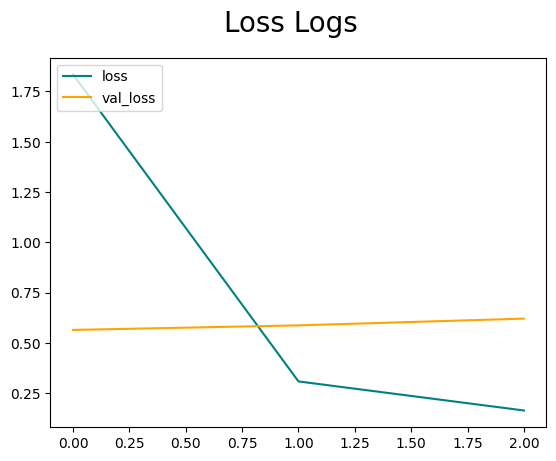

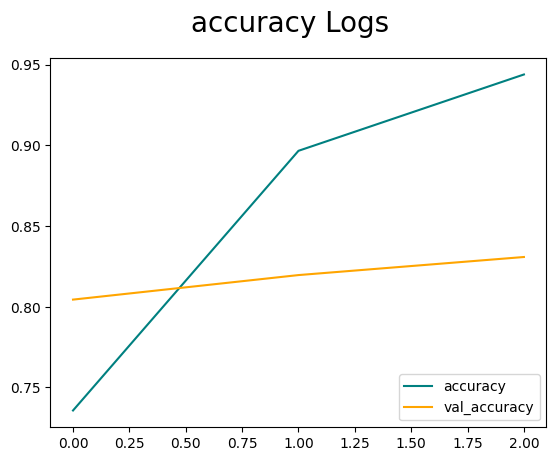

In [65]:
valid_loss, valid_accuracy = model6.evaluate(valid_data_scaled)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

# Loss Log
fig = plt.figure()
plt.plot(hist6.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist6.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m6val.png', transparent=True)
plt.show()

# Accuracy Log
fig = plt.figure()
plt.plot(hist6.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist6.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m6acc.png', transparent=True)
plt.show()

In [66]:
pre.reset_states()
re.reset_states()
acc.reset_states()

# Classification Matrix for a Model
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model6.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-20 19:58:33.921793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 19:58:52.910258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.84358525
Recall: 0.79012346
Accuracy: 0.8197531


In [67]:
y_true = []
y_pred = []

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model6.predict(X, verbose = 0)
    yhat_classes = np.argmax(yhat, axis=1)
    y_classes = np.argmax(y, axis=1)
    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.68      0.75      0.71        97
        Boat       0.76      0.72      0.74       236
      Brogue       0.84      0.94      0.88       192
        Clog       0.88      0.81      0.85       424
     Sneaker       0.82      0.86      0.84       266

    accuracy                           0.82      1215
   macro avg       0.80      0.82      0.80      1215
weighted avg       0.82      0.82      0.82      1215



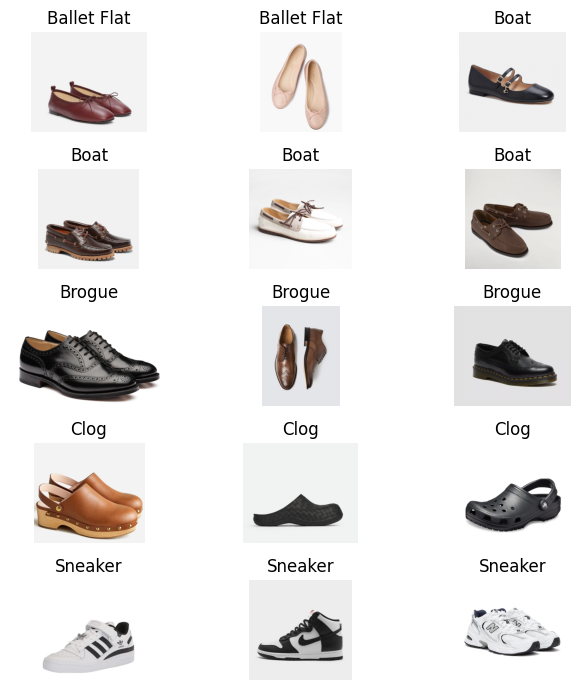

In [68]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model6.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

## 6.2.2. DenseNet201

In [69]:
des_base = DenseNet201(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

model = Sequential()
model.add(des_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax')) 

# Freeze the base model
des_base.trainable = False

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
hist7 = model.fit(train_data_scaled, 
                 epochs = 20, 
                 validation_data = valid_data_scaled, 
                 callbacks = [tensorboard_callback]
                 )

Epoch 1/20


2023-05-20 19:59:28.503494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 1.8769 - accuracy: 0.7474

2023-05-20 20:01:31.611009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 163s 487ms/step - loss: 1.8769 - accuracy: 0.7474 - val_loss: 0.5870 - val_accuracy: 0.8012
Epoch 2/20
313/313 [==============================] - 134s 429ms/step - loss: 0.3535 - accuracy: 0.8861 - val_loss: 0.5778 - val_accuracy: 0.8176
Epoch 3/20
313/313 [==============================] - 133s 423ms/step - loss: 0.1955 - accuracy: 0.9351 - val_loss: 0.7242 - val_accuracy: 0.8172
Epoch 4/20
313/313 [==============================] - 132s 420ms/step - loss: 0.1285 - accuracy: 0.9556 - val_loss: 0.8010 - val_accuracy: 0.7916
Epoch 5/20
313/313 [==============================] - 131s 418ms/step - loss: 0.1061 - accuracy: 0.9618 - val_loss: 0.9193 - val_accuracy: 0.8056
Epoch 6/20
313/313 [==============================] - 132s 423ms/step - loss: 0.0911 - accuracy: 0.9668 - val_loss: 0.8105 - val_accuracy: 0.8232
Epoch 7/20
313/313 [==============================] - 132s 421ms/step - loss: 0.0698 - accuracy: 0.9747 - val_loss: 1.0234 - val_accura

In [70]:
model.save(os.path.join('models', 'model7.h5'))
model7 = load_model('models/model7.h5')

2023-05-20 20:43:50.304244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 40s 418ms/step - loss: 1.6197 - accuracy: 0.8288
Validation loss: 1.6197172403335571, Validation accuracy: 0.8288000226020813


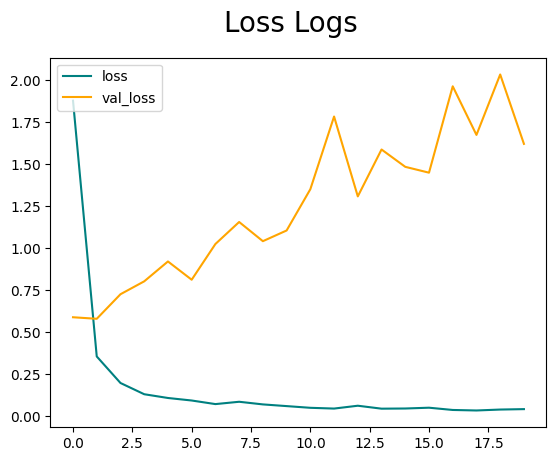

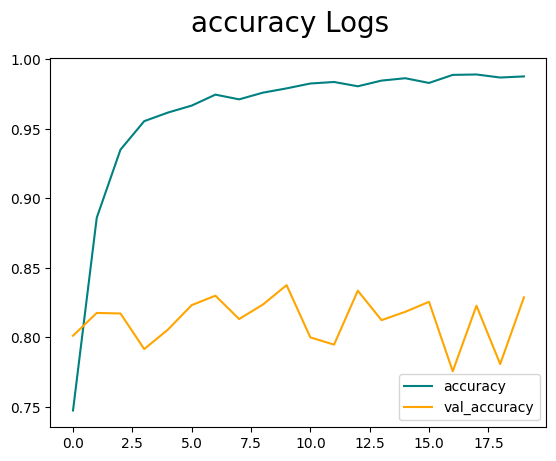

In [71]:
valid_loss, valid_accuracy = model7.evaluate(valid_data_scaled)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

fig = plt.figure()
plt.plot(hist7.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist7.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m7val.png', transparent=True)
plt.show()

fig = plt.figure()
plt.plot(hist7.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist7.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m7acc.png', transparent=True)
plt.show()

In [72]:
pre.reset_states()
re.reset_states()
acc.reset_states()

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model7.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-20 20:44:30.464565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 20:44:52.240312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.83568466
Recall: 0.8288066
Accuracy: 0.8312757


In [73]:
# Empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model7.predict(X, verbose = 0)
    # Convert predictions from probabilities to class labels
    yhat_classes = np.argmax(yhat, axis=1)
    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)
    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.77      0.76      0.77        97
        Boat       0.74      0.76      0.75       236
      Brogue       0.76      0.98      0.86       192
        Clog       0.91      0.83      0.87       424
     Sneaker       0.88      0.81      0.84       266

    accuracy                           0.83      1215
   macro avg       0.81      0.83      0.82      1215
weighted avg       0.84      0.83      0.83      1215



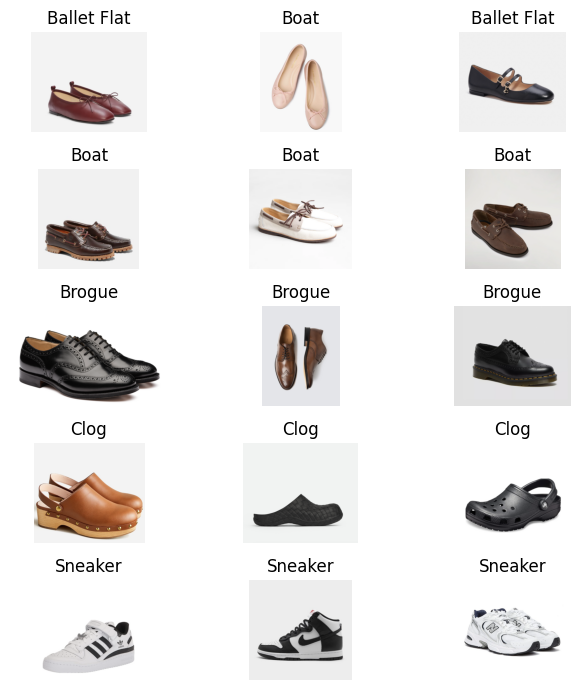

In [74]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model7.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

### Regularization

In [75]:
des_base = DenseNet201(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))
model = Sequential()
model.add(des_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax')) 
des_base.trainable = False
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Add a regularization
early_stop = EarlyStopping(monitor='val_loss', patience=2)
hist8 = model.fit(train_data_scaled, 
                 epochs = 20, 
                 validation_data = valid_data_scaled, 
                 callbacks = [early_stop, tensorboard_callback]
                 )

Epoch 1/20


2023-05-20 20:45:33.382817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 2.1361 - accuracy: 0.7424

2023-05-20 20:47:46.504707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 177s 528ms/step - loss: 2.1361 - accuracy: 0.7424 - val_loss: 0.7585 - val_accuracy: 0.7600
Epoch 2/20
313/313 [==============================] - 140s 448ms/step - loss: 0.2968 - accuracy: 0.9038 - val_loss: 0.5988 - val_accuracy: 0.8200
Epoch 3/20
313/313 [==============================] - 141s 449ms/step - loss: 0.1416 - accuracy: 0.9557 - val_loss: 0.6568 - val_accuracy: 0.8292
Epoch 4/20
313/313 [==============================] - 139s 446ms/step - loss: 0.0850 - accuracy: 0.9746 - val_loss: 0.8498 - val_accuracy: 0.8156


In [76]:
# Save the model
model.save(os.path.join('models', 'model8.h5'))
model8 = load_model('models/model8.h5')

2023-05-20 20:55:32.847895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 45s 478ms/step - loss: 0.8498 - accuracy: 0.8156
Validation loss: 0.8498367071151733, Validation accuracy: 0.8155999779701233


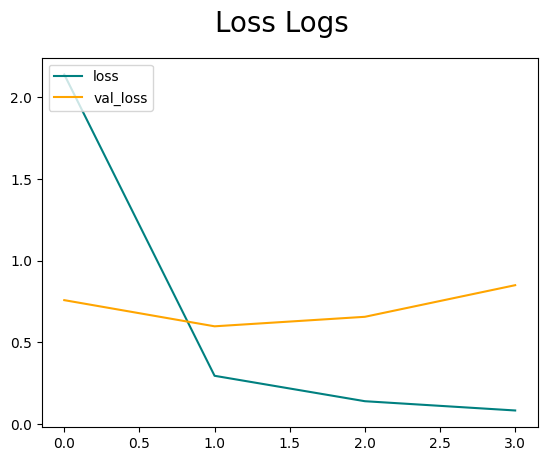

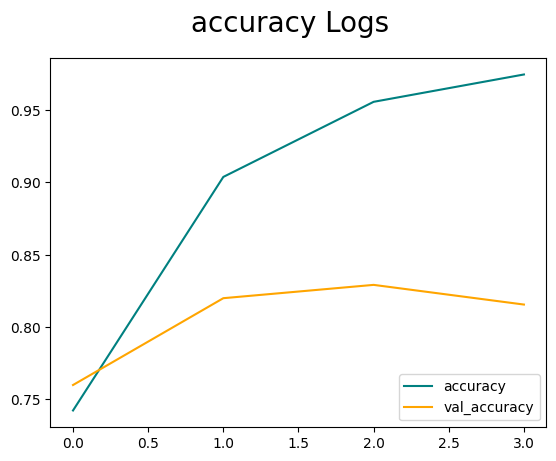

In [77]:
valid_loss, valid_accuracy = model8.evaluate(valid_data_scaled)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

# Loss Log
fig = plt.figure()
plt.plot(hist8.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist8.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m8val.png', transparent=True)
plt.show()

# Accuracy Log
fig = plt.figure()
plt.plot(hist8.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist8.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m8acc.png', transparent=True)
plt.show()

In [78]:
pre.reset_states()
re.reset_states()
acc.reset_states()

# Classification Matrix for a Model
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model8.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-20 20:56:17.613825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 20:56:41.262077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.8303946
Recall: 0.8139918
Accuracy: 0.81893003


In [79]:
y_true = []
y_pred = []

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model8.predict(X, verbose = 0)
    yhat_classes = np.argmax(yhat, axis=1)
    y_classes = np.argmax(y, axis=1)
    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.78      0.74      0.76        97
        Boat       0.84      0.59      0.69       236
      Brogue       0.71      0.98      0.83       192
        Clog       0.89      0.86      0.88       424
     Sneaker       0.81      0.87      0.84       266

    accuracy                           0.82      1215
   macro avg       0.81      0.81      0.80      1215
weighted avg       0.83      0.82      0.82      1215



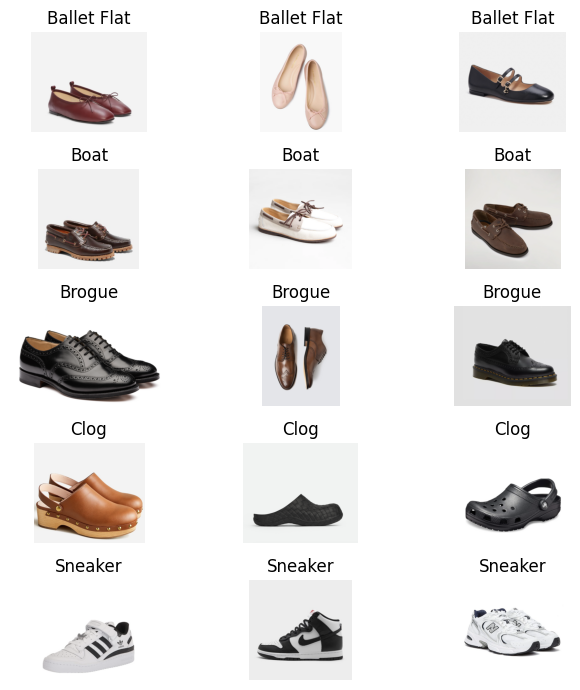

In [80]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model8.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

### 6.2.3. EfficientNetB1

In [81]:
eff_base = EfficientNetB1(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

model = Sequential()
model.add(eff_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax')) 

# Freeze the base model
eff_base.trainable = False

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
hist9 = model.fit(train_data_scaled, 
                 epochs = 20, 
                 validation_data = valid_data_scaled, 
                 callbacks = [tensorboard_callback]
                 )

Epoch 1/20


2023-05-20 20:57:19.792967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 3.8303 - accuracy: 0.2040

2023-05-20 20:58:32.698519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 106s 293ms/step - loss: 3.8303 - accuracy: 0.2040 - val_loss: 1.6668 - val_accuracy: 0.2000
Epoch 2/20
313/313 [==============================] - 62s 197ms/step - loss: 1.6748 - accuracy: 0.2036 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 3/20
313/313 [==============================] - 60s 190ms/step - loss: 1.6096 - accuracy: 0.1932 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 4/20
313/313 [==============================] - 61s 196ms/step - loss: 1.6096 - accuracy: 0.1947 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 5/20
313/313 [==============================] - 59s 188ms/step - loss: 1.6096 - accuracy: 0.1930 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 6/20
313/313 [==============================] - 61s 194ms/step - loss: 1.6096 - accuracy: 0.1959 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 7/20
313/313 [==============================] - 60s 191ms/step - loss: 1.6096 - accuracy: 0.1940 - val_loss: 1.6094 - val_accuracy: 0.

In [82]:
# Save the model
model.save(os.path.join('models', 'model9.h5'))
model9 = load_model('models/model9.h5')

2023-05-20 21:17:58.337230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 31s 306ms/step - loss: 1.6094 - accuracy: 0.2000
Validation loss: 1.6094403266906738, Validation accuracy: 0.20000000298023224


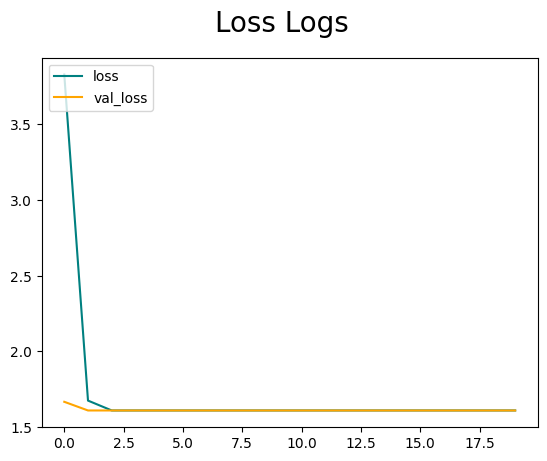

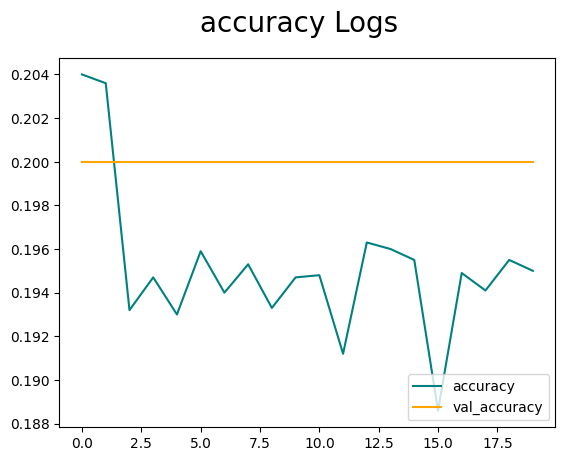

In [83]:
valid_loss, valid_accuracy = model9.evaluate(valid_data_scaled)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

fig = plt.figure()
plt.plot(hist9.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist9.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m9val.png', transparent=True)
plt.show()

fig = plt.figure()
plt.plot(hist9.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist9.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m9acc.png', transparent=True)
plt.show()

In [84]:
pre.reset_states()
re.reset_states()
acc.reset_states()

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model9.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-20 21:18:29.699221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 21:18:45.430849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.0
Recall: 0.0
Accuracy: 0.07983539


In [85]:
# Empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model9.predict(X, verbose = 0)

    # Convert predictions from probabilities to class labels
    yhat_classes = np.argmax(yhat, axis=1)

    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.08      1.00      0.15        97
        Boat       0.00      0.00      0.00       236
      Brogue       0.00      0.00      0.00       192
        Clog       0.00      0.00      0.00       424
     Sneaker       0.00      0.00      0.00       266

    accuracy                           0.08      1215
   macro avg       0.02      0.20      0.03      1215
weighted avg       0.01      0.08      0.01      1215



/Users/misunsong/miniconda/envs/tf-cert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/misunsong/miniconda/envs/tf-cert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/misunsong/miniconda/envs/tf-cert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

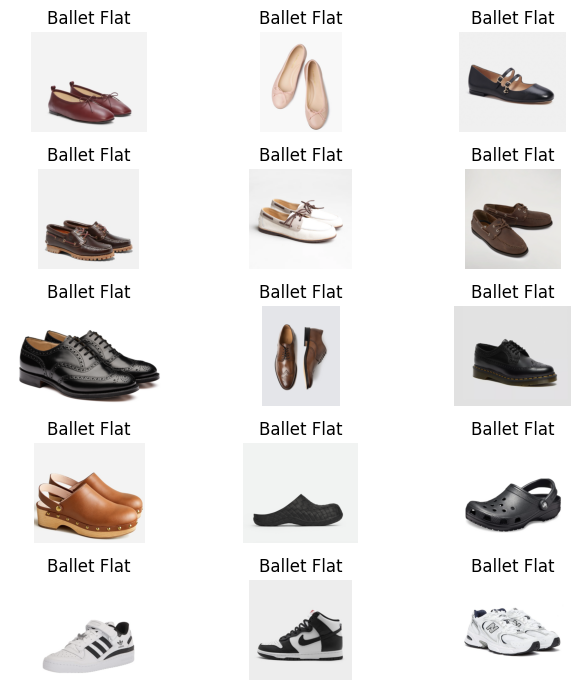

In [86]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model9.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

In [87]:
eff_base = EfficientNetB1(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))
model = Sequential()
model.add(eff_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax')) 
eff_base.trainable = False
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Add a regularization
early_stop = EarlyStopping(monitor='val_loss', patience=2)
hist10 = model.fit(train_data_scaled,
                   epochs = 20,
                   validation_data = valid_data_scaled, 
                   callbacks = [early_stop, tensorboard_callback]
                  )

Epoch 1/20


2023-05-20 21:19:18.741191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 5.0778 - accuracy: 0.2000

2023-05-20 21:20:36.074402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 113s 312ms/step - loss: 5.0778 - accuracy: 0.2000 - val_loss: 2.3493 - val_accuracy: 0.2008
Epoch 2/20
313/313 [==============================] - 61s 193ms/step - loss: 2.3302 - accuracy: 0.1983 - val_loss: 1.9157 - val_accuracy: 0.2000
Epoch 3/20
313/313 [==============================] - 62s 199ms/step - loss: 1.8023 - accuracy: 0.2087 - val_loss: 1.7383 - val_accuracy: 0.2160
Epoch 4/20
313/313 [==============================] - 63s 201ms/step - loss: 1.6942 - accuracy: 0.2050 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 5/20
313/313 [==============================] - 59s 189ms/step - loss: 1.6095 - accuracy: 0.1951 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 6/20
313/313 [==============================] - 59s 189ms/step - loss: 1.6095 - accuracy: 0.1952 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 7/20
313/313 [==============================] - 61s 196ms/step - loss: 1.6095 - accuracy: 0.1887 - val_loss: 1.6094 - val_accuracy: 0.

In [88]:
# Save the model
model.save(os.path.join('models', 'model10.h5'))
model10 = load_model('models/model10.h5')

2023-05-20 21:28:17.850983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 34s 330ms/step - loss: 1.6094 - accuracy: 0.2000
Validation loss: 1.6094396114349365, Validation accuracy: 0.20000000298023224


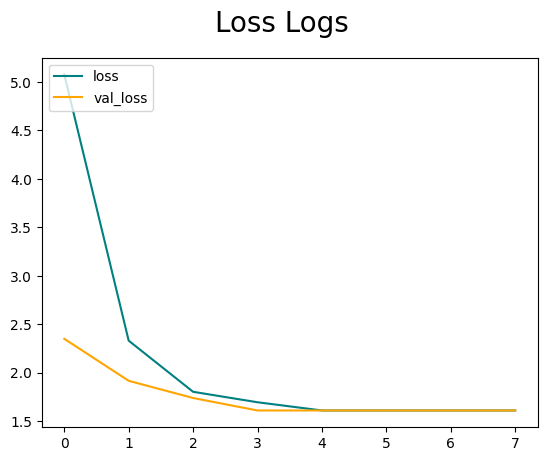

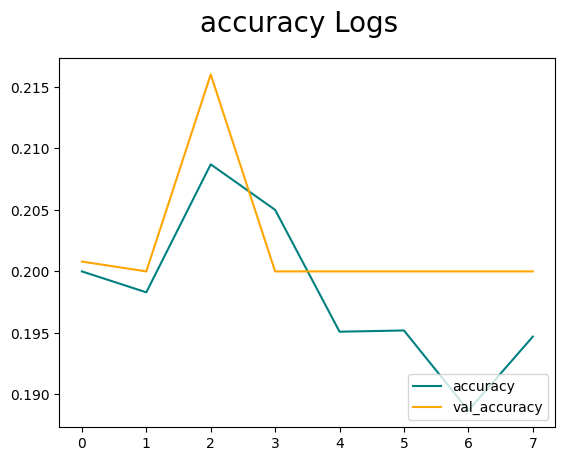

In [89]:
valid_loss, valid_accuracy = model10.evaluate(valid_data_scaled)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

# Loss Log
fig = plt.figure()
plt.plot(hist10.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist10.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m10val.png', transparent=True)
plt.show()

# Accuracy Log
fig = plt.figure()
plt.plot(hist10.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist10.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m10acc.png', transparent=True)
plt.show()

In [90]:
pre.reset_states()
re.reset_states()
acc.reset_states()

# Classification Matrix for a Model
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model10.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-20 21:28:52.009325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 21:29:08.662933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.0
Recall: 0.0
Accuracy: 0.21893004


In [91]:
y_true = []
y_pred = []

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model10.predict(X, verbose = 0)

    yhat_classes = np.argmax(yhat, axis=1)

    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.00      0.00      0.00        97
        Boat       0.00      0.00      0.00       236
      Brogue       0.00      0.00      0.00       192
        Clog       0.00      0.00      0.00       424
     Sneaker       0.22      1.00      0.36       266

    accuracy                           0.22      1215
   macro avg       0.04      0.20      0.07      1215
weighted avg       0.05      0.22      0.08      1215



/Users/misunsong/miniconda/envs/tf-cert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/misunsong/miniconda/envs/tf-cert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/misunsong/miniconda/envs/tf-cert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

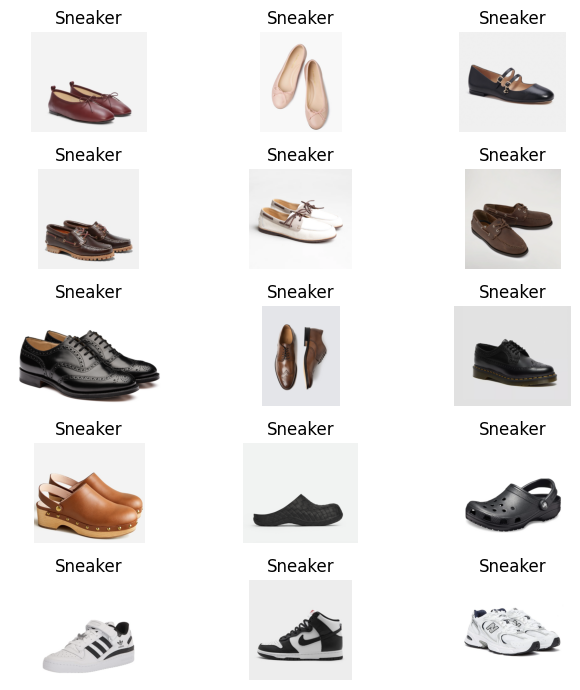

In [92]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model10.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

## 6.3. Data Augmentation + Transfer learning

### 6.3.1. DenseNet201

In [93]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_data_gen = datagen.flow_from_directory(train_dir, target_size=(256, 256), class_mode='categorical')
valid_data_gen = datagen.flow_from_directory(valid_dir, target_size=(256, 256), class_mode='categorical')

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


In [94]:
model8 = load_model('models/model8.h5')

hist11 = model8.fit(train_data_gen,
                    epochs=50,
                    validation_data=valid_data_gen,
                    callbacks = [tensorboard_callback]
                   )

Epoch 1/50


2023-05-20 21:29:40.915806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.7579

2023-05-20 21:32:24.806523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 228s 671ms/step - loss: 0.7330 - accuracy: 0.7579 - val_loss: 0.7580 - val_accuracy: 0.7460
Epoch 2/50
313/313 [==============================] - 157s 502ms/step - loss: 0.5497 - accuracy: 0.8142 - val_loss: 0.5755 - val_accuracy: 0.8068
Epoch 3/50
313/313 [==============================] - 156s 499ms/step - loss: 0.4826 - accuracy: 0.8371 - val_loss: 0.5438 - val_accuracy: 0.8076
Epoch 4/50
313/313 [==============================] - 156s 499ms/step - loss: 0.4733 - accuracy: 0.8354 - val_loss: 0.5756 - val_accuracy: 0.8012
Epoch 5/50
313/313 [==============================] - 159s 509ms/step - loss: 0.4636 - accuracy: 0.8410 - val_loss: 0.6184 - val_accuracy: 0.7900
Epoch 6/50
313/313 [==============================] - 162s 517ms/step - loss: 0.4500 - accuracy: 0.8459 - val_loss: 0.5945 - val_accuracy: 0.8020
Epoch 7/50
313/313 [==============================] - 156s 496ms/step - loss: 0.4363 - accuracy: 0.8580 - val_loss: 0.5184 - val_accura

In [95]:
# Save the model
model8.save(os.path.join('models', 'model11.h5'))
model11 = load_model('models/model11.h5')

2023-05-20 23:39:06.704826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 61s 633ms/step - loss: 0.5980 - accuracy: 0.8232
Validation loss: 0.5979710817337036, Validation accuracy: 0.823199987411499


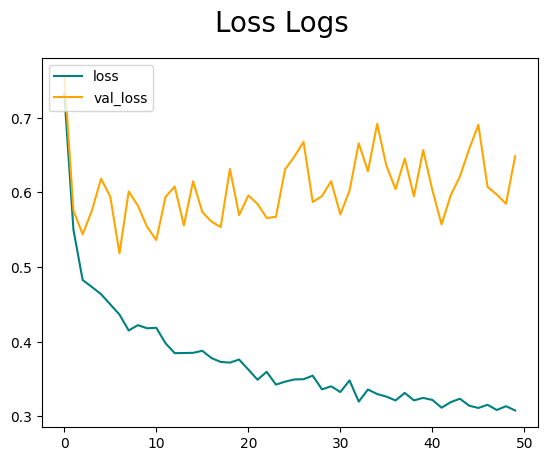

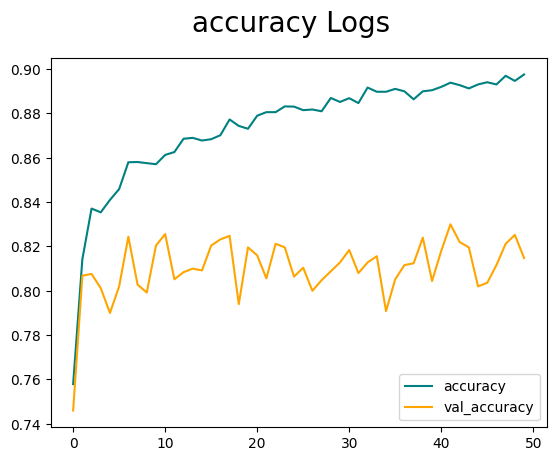

In [96]:
valid_loss, valid_accuracy = model11.evaluate(valid_data_gen)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

fig = plt.figure()
plt.plot(hist11.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist11.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m11val.png', transparent=True)
plt.show()

fig = plt.figure()
plt.plot(hist11.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist11.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m11acc.png', transparent=True)
plt.show()

In [97]:
pre.reset_states()
re.reset_states()
acc.reset_states()

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model11.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-20 23:40:08.154461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-20 23:40:46.149423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.84273505
Recall: 0.81152266
Accuracy: 0.82222223


In [98]:
# Empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model11.predict(X, verbose = 0)

    # Convert predictions from probabilities to class labels
    yhat_classes = np.argmax(yhat, axis=1)

    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.71      0.75      0.73        97
        Boat       0.77      0.67      0.72       236
      Brogue       0.74      0.97      0.84       192
        Clog       0.91      0.84      0.87       424
     Sneaker       0.86      0.85      0.86       266

    accuracy                           0.82      1215
   macro avg       0.80      0.82      0.80      1215
weighted avg       0.83      0.82      0.82      1215



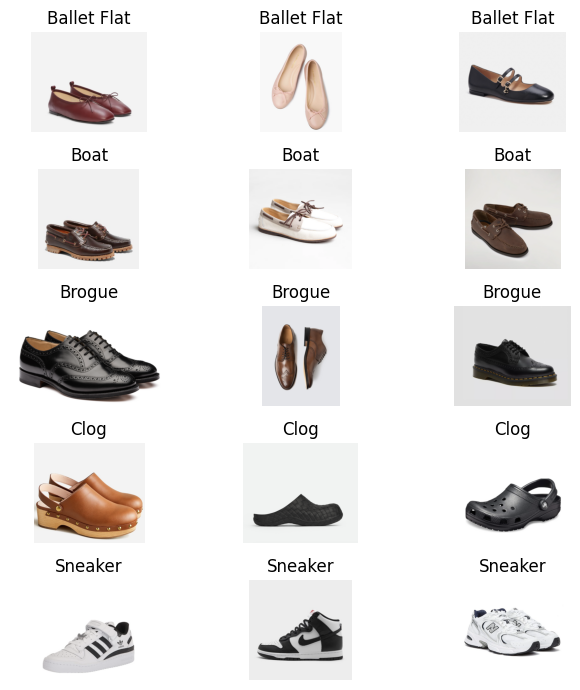

In [99]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model11.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

### Regularization

In [100]:
# Add a regularization
model8 = load_model('models/model8.h5')

early_stop = EarlyStopping(monitor='val_loss', patience=5)
hist12 = model8.fit(train_data_gen,
                    epochs=50,
                    validation_data=valid_data_gen,
                    callbacks = [early_stop, tensorboard_callback]
                   )

Epoch 1/50


2023-05-20 23:41:37.424537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.7571

2023-05-20 23:44:23.707461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 230s 689ms/step - loss: 0.7396 - accuracy: 0.7571 - val_loss: 0.6361 - val_accuracy: 0.7808
Epoch 2/50
313/313 [==============================] - 170s 544ms/step - loss: 0.5651 - accuracy: 0.8076 - val_loss: 0.6451 - val_accuracy: 0.7840
Epoch 3/50
313/313 [==============================] - 164s 523ms/step - loss: 0.4883 - accuracy: 0.8309 - val_loss: 0.5609 - val_accuracy: 0.8060
Epoch 4/50
313/313 [==============================] - 161s 515ms/step - loss: 0.4686 - accuracy: 0.8396 - val_loss: 0.5768 - val_accuracy: 0.8000
Epoch 5/50
313/313 [==============================] - 164s 523ms/step - loss: 0.4594 - accuracy: 0.8421 - val_loss: 0.6040 - val_accuracy: 0.7960
Epoch 6/50
313/313 [==============================] - 162s 516ms/step - loss: 0.4383 - accuracy: 0.8504 - val_loss: 0.5924 - val_accuracy: 0.7864
Epoch 7/50
313/313 [==============================] - 163s 521ms/step - loss: 0.4402 - accuracy: 0.8533 - val_loss: 0.5973 - val_accura

In [101]:
# Save the model
model8.save(os.path.join('models', 'model12.h5'))
model12 = load_model('models/model12.h5')

79/79 [==============================] - 54s 672ms/step - loss: 0.7397 - accuracy: 0.7636
Validation loss: 0.7397110462188721, Validation accuracy: 0.7635999917984009


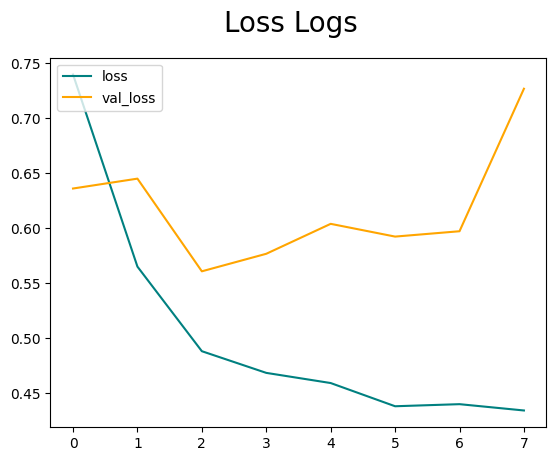

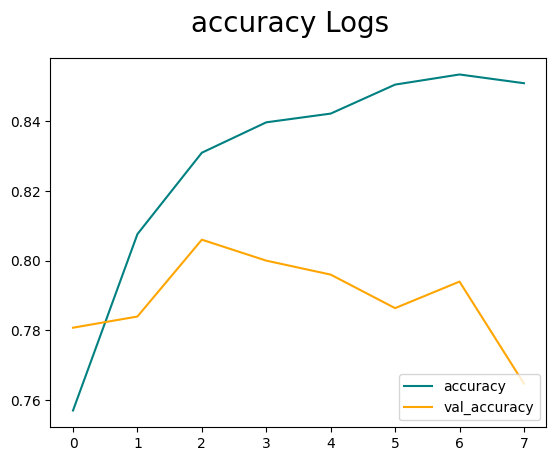

In [145]:
valid_loss, valid_accuracy = model12.evaluate(valid_data_gen)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

fig = plt.figure()
plt.plot(hist12.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist12.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m12val.png', transparent=True)
plt.show()

fig = plt.figure()
plt.plot(hist12.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist12.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m12acc.png', transparent=True)
plt.show()

In [103]:
pre.reset_states()
re.reset_states()
acc.reset_states()

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model12.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-21 00:05:45.016288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-21 00:06:15.557334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.8229706
Recall: 0.78436214
Accuracy: 0.80246913


In [104]:
y_true = []
y_pred = []

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model12.predict(X, verbose = 0)

    yhat_classes = np.argmax(yhat, axis=1)

    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.80      0.55      0.65        97
        Boat       0.68      0.79      0.73       236
      Brogue       0.87      0.78      0.82       192
        Clog       0.88      0.82      0.85       424
     Sneaker       0.77      0.89      0.83       266

    accuracy                           0.80      1215
   macro avg       0.80      0.77      0.78      1215
weighted avg       0.81      0.80      0.80      1215



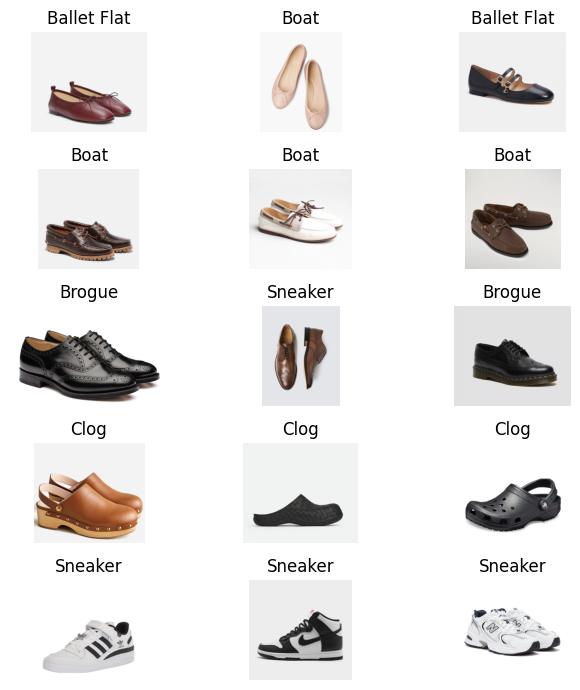

In [105]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model12.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

### 6.3.2. ResNet152V2

In [113]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_data_gen = datagen.flow_from_directory(train_dir, target_size=(256, 256), class_mode='categorical')
valid_data_gen = datagen.flow_from_directory(valid_dir, target_size=(256, 256), class_mode='categorical')

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


In [114]:
model6 = load_model('models/model6.h5')

hist13 = model6.fit(train_data_gen,
                    epochs=50,
                    validation_data=valid_data_gen,
                    callbacks = [tensorboard_callback]
                   )

Epoch 1/50


2023-05-21 09:08:38.295404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.8018 - accuracy: 0.7381

2023-05-21 09:11:38.842185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 258s 747ms/step - loss: 0.8018 - accuracy: 0.7381 - val_loss: 0.6802 - val_accuracy: 0.7684
Epoch 2/50
313/313 [==============================] - 158s 505ms/step - loss: 0.6178 - accuracy: 0.7840 - val_loss: 0.6518 - val_accuracy: 0.7752
Epoch 3/50
313/313 [==============================] - 158s 503ms/step - loss: 0.5719 - accuracy: 0.8083 - val_loss: 0.6691 - val_accuracy: 0.7704
Epoch 4/50
313/313 [==============================] - 166s 530ms/step - loss: 0.5445 - accuracy: 0.8193 - val_loss: 0.6072 - val_accuracy: 0.7908
Epoch 5/50
313/313 [==============================] - 165s 527ms/step - loss: 0.5179 - accuracy: 0.8252 - val_loss: 0.6499 - val_accuracy: 0.7788
Epoch 6/50
313/313 [==============================] - 168s 535ms/step - loss: 0.4886 - accuracy: 0.8357 - val_loss: 0.6382 - val_accuracy: 0.7864
Epoch 7/50
313/313 [==============================] - 168s 538ms/step - loss: 0.4968 - accuracy: 0.8338 - val_loss: 0.6573 - val_accura

In [115]:
# Save the model
model6.save(os.path.join('models', 'model13.h5'))
model13 = load_model('models/model13.h5')

79/79 [==============================] - 41s 511ms/step - loss: 0.7101 - accuracy: 0.7876
Validation loss: 0.7101117372512817, Validation accuracy: 0.7875999808311462


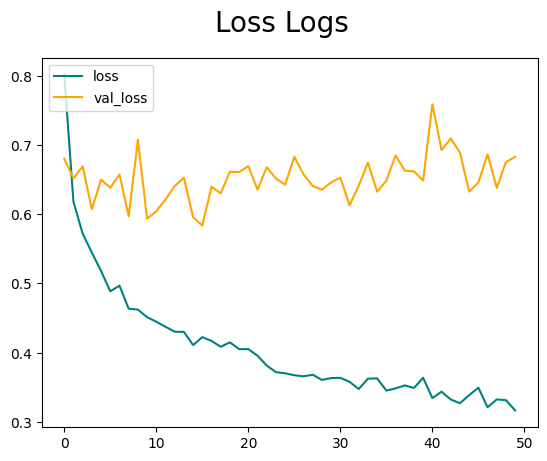

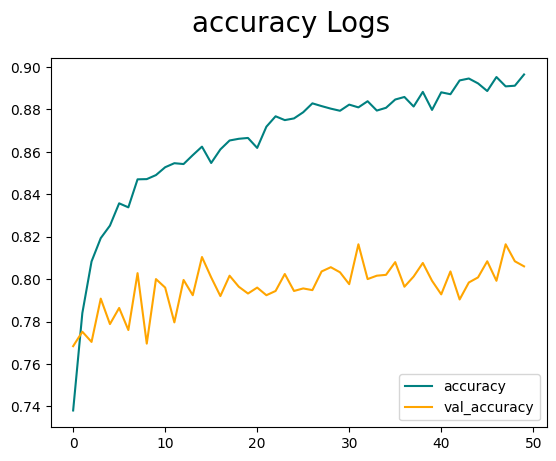

In [146]:
valid_loss, valid_accuracy = model13.evaluate(valid_data_gen)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

fig = plt.figure()
plt.plot(hist13.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist13.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m13val.png', transparent=True)
plt.show()

fig = plt.figure()
plt.plot(hist13.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist13.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m13acc.png', transparent=True)
plt.show()

In [117]:
pre.reset_states()
re.reset_states()
acc.reset_states()

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model13.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-21 12:36:57.437242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-21 12:37:36.537116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.8393013
Recall: 0.7909465
Accuracy: 0.8172839


In [118]:
# Empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model13.predict(X, verbose = 0)

    # Convert predictions from probabilities to class labels
    yhat_classes = np.argmax(yhat, axis=1)

    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.64      0.76      0.69        97
        Boat       0.73      0.76      0.75       236
      Brogue       0.79      0.96      0.87       192
        Clog       0.91      0.82      0.86       424
     Sneaker       0.87      0.78      0.83       266

    accuracy                           0.82      1215
   macro avg       0.79      0.82      0.80      1215
weighted avg       0.83      0.82      0.82      1215



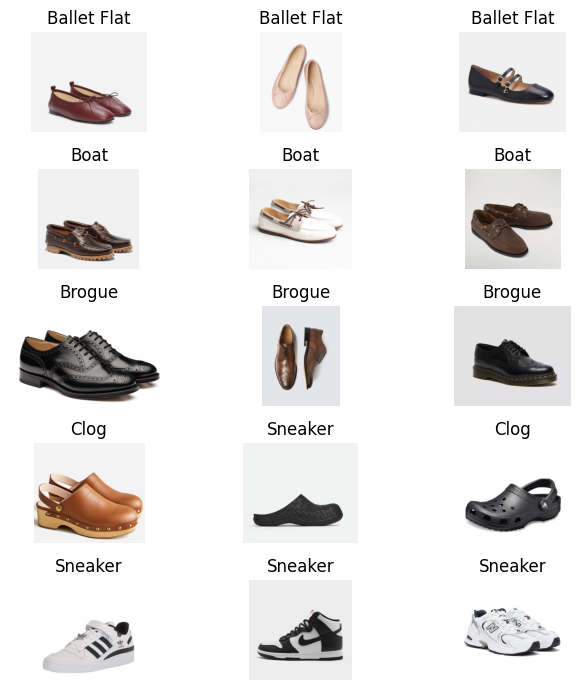

In [119]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model13.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

### Regularization

In [120]:
# Add a regularization
model6 = load_model('models/model6.h5')

early_stop = EarlyStopping(monitor='val_loss', patience=5)
hist14 = model6.fit(train_data_gen,
                    epochs=50,
                    validation_data=valid_data_gen,
                    callbacks = [early_stop, tensorboard_callback]
                   )

Epoch 1/50


2023-05-21 12:38:42.301322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.7873 - accuracy: 0.7456

2023-05-21 12:41:21.500021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 226s 682ms/step - loss: 0.7873 - accuracy: 0.7456 - val_loss: 0.6849 - val_accuracy: 0.7724
Epoch 2/50
313/313 [==============================] - 159s 507ms/step - loss: 0.6260 - accuracy: 0.7916 - val_loss: 0.6619 - val_accuracy: 0.7708
Epoch 3/50
313/313 [==============================] - 156s 499ms/step - loss: 0.5744 - accuracy: 0.8059 - val_loss: 0.6733 - val_accuracy: 0.7664
Epoch 4/50
313/313 [==============================] - 155s 495ms/step - loss: 0.5540 - accuracy: 0.8145 - val_loss: 0.7081 - val_accuracy: 0.7616
Epoch 5/50
313/313 [==============================] - 158s 503ms/step - loss: 0.5324 - accuracy: 0.8212 - val_loss: 0.6366 - val_accuracy: 0.7792
Epoch 6/50
313/313 [==============================] - 149s 476ms/step - loss: 0.5102 - accuracy: 0.8260 - val_loss: 0.6423 - val_accuracy: 0.7796
Epoch 7/50
313/313 [==============================] - 149s 476ms/step - loss: 0.5027 - accuracy: 0.8308 - val_loss: 0.6224 - val_accura

In [121]:
# Save the model
model6.save(os.path.join('models', 'model14.h5'))
model14 = load_model('models/model14.h5')

79/79 [==============================] - 48s 538ms/step - loss: 0.6380 - accuracy: 0.7880
Validation loss: 0.6379915475845337, Validation accuracy: 0.7879999876022339


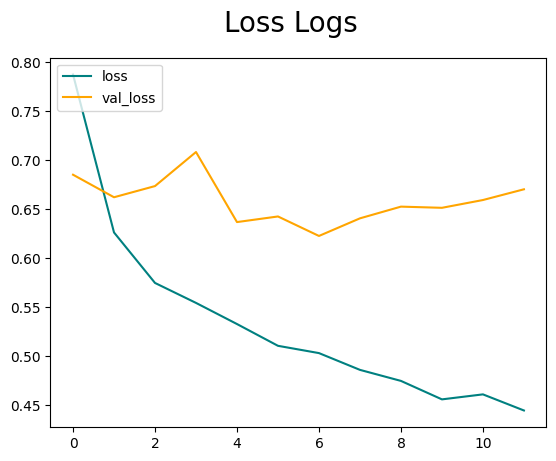

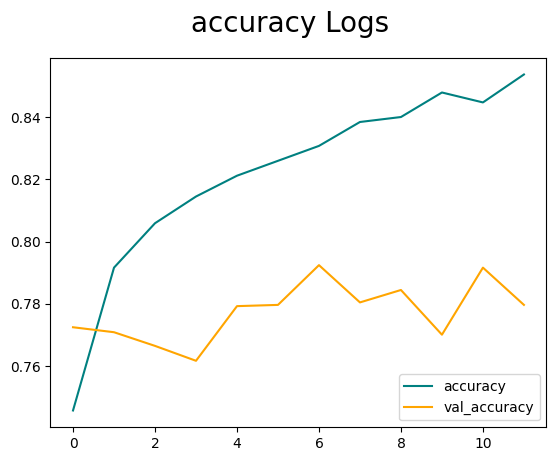

In [147]:
valid_loss, valid_accuracy = model14.evaluate(valid_data_gen)
print(f'Validation loss: {valid_loss}, Validation accuracy: {valid_accuracy}')

fig = plt.figure()
plt.plot(hist14.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist14.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss Logs', fontsize = 20)
plt.legend(loc = 'upper left')
plt.savefig('plots/m14val.png', transparent=True)
plt.show()

fig = plt.figure()
plt.plot(hist14.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist14.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('accuracy Logs', fontsize = 20)
plt.legend(loc = 'lower right')
plt.savefig('plots/m14acc.png', transparent=True)
plt.show()

In [123]:
pre.reset_states()
re.reset_states()
acc.reset_states()

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model14.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print('Precision:', pre.result().numpy()) 
print('Recall:', re.result().numpy()) 
print('Accuracy:', acc.result().numpy())

2023-05-21 13:11:53.251451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-21 13:12:36.491283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision: 0.8276481
Recall: 0.7588477
Accuracy: 0.7942387


In [124]:
y_true = []
y_pred = []

for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    yhat = model14.predict(X, verbose = 0)

    yhat_classes = np.argmax(yhat, axis=1)

    y_classes = np.argmax(y, axis=1)

    y_true.extend(y_classes)
    y_pred.extend(yhat_classes)

report = classification_report(y_true, y_pred, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)

              precision    recall  f1-score   support

 Ballet Flat       0.65      0.77      0.71        97
        Boat       0.76      0.63      0.69       236
      Brogue       0.69      0.97      0.81       192
        Clog       0.88      0.83      0.86       424
     Sneaker       0.86      0.76      0.81       266

    accuracy                           0.79      1215
   macro avg       0.77      0.79      0.77      1215
weighted avg       0.81      0.79      0.79      1215



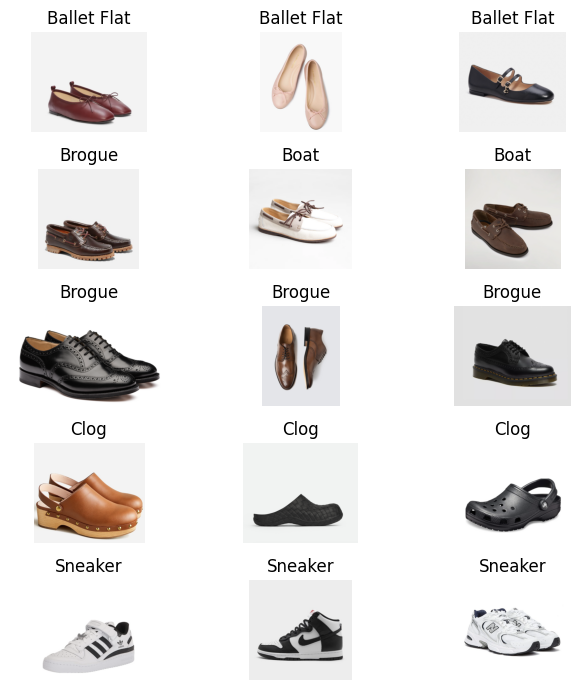

In [125]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot
    
    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values
    
    yhat = model14.predict(resize, verbose = 0)
    
    predicted_class_index = np.argmax(yhat, axis =1)
    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid

# 6.4. Ensemble Techniques
- We take the pre-trained models (like ResNet and DenseNet), fine-tune them on your training data independently.
- Then make predictions on our test data, and aggregate these predictions, then this approach is a type of ensemble learning. 
- Each model has independently adapted to your task (through fine-tuning), and you're combining their predictions to make a final decision.

In [144]:
# Empty lists to store true and predicted labels
y_true = []
y_preds = []

# Define the models to combine
models = [model11, model13]

# Iterate over the test data
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    temp_preds = np.zeros((len(y), 5))  # num_classes: number of classes in your problem
    
    for model in models:
        yhat = model.predict(X, verbose=0)
        temp_preds += yhat  # summing up the prediction probabilities
    
    # Average the predictions
    avg_preds = temp_preds / len(models)
    
    # Convert averaged predictions from probabilities to class labels
    yhat_classes = np.argmax(avg_preds, axis=1)
    
    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)
    y_true.extend(y_classes)
    y_preds.extend(yhat_classes)

# Generate classification report
report = classification_report(y_true, y_preds, output_dict=True)

# Extract precision, recall, and accuracy
# tf.keras.metrics.Precision, tf.keras.metrics.Recall, and tf.keras.metrics.Accuracy metrics from TensorFlow, by default, they calculate the weighted average of precision, recall, and accuracy. 
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
accuracy = report['accuracy']

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.8562660331279134
Recall: 0.8493827160493828
Accuracy: 0.8493827160493828


In [127]:
# Empty lists to store true and predicted labels
y_true = []
y_preds = []

# Define all models from which you want to ensemble the predictions
models = [model11, model13]  # We can decide whether to use one trained with augmented data or only scaled data. 

# Iterate over the test data
for batch in test_data_scaled.as_numpy_iterator():
    X, y = batch
    temp_preds = np.zeros((len(y), 5))  # num_classes: number of classes in your problem
    
    for model in models:
        yhat = model.predict(X, verbose=0)
        temp_preds += yhat  # summing up the prediction probabilities
    
    # Average the predictions
    avg_preds = temp_preds / len(models)
    
    # Convert averaged predictions from probabilities to class labels
    yhat_classes = np.argmax(avg_preds, axis=1)
    
    # Convert true labels from one-hot encoded to class labels
    y_classes = np.argmax(y, axis=1)
    y_true.extend(y_classes)
    y_preds.extend(yhat_classes)

# Generate classification report
report = classification_report(y_true, y_preds, target_names=['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'])

print(report)


              precision    recall  f1-score   support

 Ballet Flat       0.73      0.82      0.77        97
        Boat       0.79      0.77      0.78       236
      Brogue       0.78      0.98      0.87       192
        Clog       0.93      0.84      0.89       424
     Sneaker       0.89      0.85      0.87       266

    accuracy                           0.85      1215
   macro avg       0.83      0.85      0.84      1215
weighted avg       0.86      0.85      0.85      1215



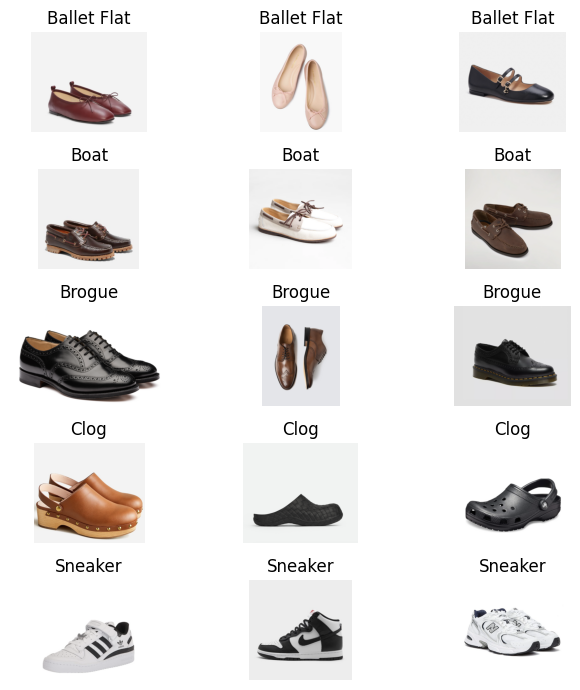

In [128]:
fig, axs = plt.subplots(5, 3, figsize=(7, 7))  # Create a 5x3 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over

for i, shoes in enumerate(shoe_list2):
    img = cv2.imread(f'unknown/{shoes}.png')  # use the shoe type in the filename
    if img is None:
        print(f"Image not loaded: unknown/{shoes}.png")
        continue

    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display image in subplot

    resize = tf.image.resize(img, [256, 256])
    resize = np.expand_dims(resize, axis=0)
    resize = resize / 255.0  # normalize the pixel values

    temp_preds = np.zeros((1, 5))  # num_classes: number of classes in your problem
    for model in models:
        yhat = model.predict(resize, verbose=0)
        temp_preds += yhat  # summing up the prediction probabilities
    
    # Average the predictions
    avg_preds = temp_preds / len(models)
    
    # Convert averaged predictions from probabilities to class labels
    predicted_class_index = np.argmax(avg_preds, axis=1)

    predicted_class_name = class_dict2[predicted_class_index[0]]
    axs[i].set_title(predicted_class_name)  # Add title to subplot with the predicted class name
    axs[i].axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust subplot parameters for better fit
plt.show()  # Display the full grid
